In [1]:
#Dependecies 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.stats import mannwhitneyu
import numpy as np

# Python Api Dependencies
import requests
import json
from pprint import pprint
import hvplot.pandas
from scipy.stats import linregress
# conda install -c conda-forge geopandas
import geopandas as gpd
# pip install pycountry
import pycountry
from mplcursors import cursor  # separate package must be installed

# Import the API key
from api_keys import geoapify_key

# Turn off warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in the WHR_2023 data
whr_df = pd.read_csv("../Resources/WHR_2023.csv")
whr_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.168,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.191,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.121,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.164,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.238,0.776,0.614,0.268


In [3]:
#rename columns
whr_df.columns = ["Country", "Year", "Happiness Score", "GDP p/capita", "Social Support",
                  "Healthy Life Expectancy", "Life Choices Freedom", "Generosity",
                  "Corruption Perceptions", "Positive Affect", "Negative Effect"]
whr_df

,Country,Year,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.168,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.191,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.121,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.164,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.238,0.776,0.614,0.268
...,...,...,...,...,...,...,...,...,...,...,...
2194,Zimbabwe,2018,3.616,7.783,0.775,52.625,0.763,-0.051,0.844,0.658,0.212
2195,Zimbabwe,2019,2.694,7.698,0.759,53.100,0.632,-0.047,0.831,0.658,0.235
2196,Zimbabwe,2020,3.160,7.596,0.717,53.575,0.643,0.006,0.789,0.661,0.346
2197,Zimbabwe,2021,3.155,7.657,0.685,54.050,0.668,-0.076,0.757,0.610,0.242


# Clean Data Frame

In [4]:
# Filter by years that we are working with 
whr_clean_df = whr_df.loc[whr_df["Year"] >= 2012]
whr_clean_df = whr_clean_df.reset_index(drop=True)
whr_clean_df

#drop Nan values in GDP column
whr_clean_df = whr_clean_df.dropna(subset=["GDP p/capita", "Healthy Life Expectancy", "Corruption Perceptions"])
whr_clean_df



,Country,Year,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
0,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.238,0.776,0.614,0.268
1,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.063,0.823,0.547,0.273
2,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.106,0.871,0.492,0.375
3,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.082,0.881,0.491,0.339
4,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.044,0.793,0.501,0.348
...,...,...,...,...,...,...,...,...,...,...,...
1482,Zimbabwe,2018,3.616,7.783,0.775,52.625,0.763,-0.051,0.844,0.658,0.212
1483,Zimbabwe,2019,2.694,7.698,0.759,53.100,0.632,-0.047,0.831,0.658,0.235
1484,Zimbabwe,2020,3.160,7.596,0.717,53.575,0.643,0.006,0.789,0.661,0.346
1485,Zimbabwe,2021,3.155,7.657,0.685,54.050,0.668,-0.076,0.757,0.610,0.242


In [5]:
#finding Nan values 
nan_df = whr_clean_df[(whr_clean_df["GDP p/capita"].isna()) | (whr_clean_df["Healthy Life Expectancy"].isna())]
nan_country_year_df = nan_df[["Country", "Year", "GDP p/capita", "Healthy Life Expectancy"]]
sorted_nan_country = nan_country_year_df.sort_values(by="Year", ascending=True)
# print(nan_df.isna().sum())

# Grouped by year - All Countries

In [6]:
#group by year
grouped_clean_df = whr_clean_df.groupby(["Year"]).mean()
grouped_clean_df                         

,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
Year,,,,,,,,,
2012,5.421103,9.362579,0.807563,62.916032,0.704889,-0.008595,0.761889,0.641476,0.263468
2013,5.352357,9.339524,0.804532,62.945873,0.728384,-0.003656,0.761770,0.655288,0.271540
2014,5.364062,9.309877,0.806892,62.975692,0.737677,0.019062,0.739315,0.658868,0.272015
2015,5.375070,9.324711,0.796031,63.286719,0.750391,0.016078,0.735211,0.658859,0.277352
2016,5.383480,9.340448,0.810376,63.373200,0.762720,0.000096,0.747152,0.658944,0.286904
2017,5.486492,9.346409,0.805515,63.549242,0.782674,-0.007273,0.728288,0.653765,0.290205
2018,5.509415,9.365685,0.809392,63.810962,0.780178,-0.027538,0.732508,0.653523,0.295115
2019,5.554725,9.394740,0.813191,64.056489,0.791654,-0.023831,0.723221,0.657160,0.289725
2020,5.735377,9.595406,0.824557,65.531604,0.808762,-0.004934,0.726953,0.665264,0.304462


# Group by Country - Average of years (2011-2021)

In [7]:
#group by country to plot scatter plot and linregress 
grouped_by_country = whr_clean_df.groupby(["Country"])[["Happiness Score", "GDP p/capita", "Healthy Life Expectancy", "Corruption Perceptions", "Social Support"]].mean()
grouped_by_country

,Happiness Score,GDP p/capita,Healthy Life Expectancy,Corruption Perceptions,Social Support
Country,,,,,
Afghanistan,3.206222,7.617667,52.977778,0.877333,0.499111
Albania,4.951273,9.454273,68.910909,0.882000,0.690091
Algeria,5.216167,9.339667,66.283333,0.721000,0.826167
Angola,4.030667,8.999667,52.460000,0.852000,0.743333
Argentina,6.257545,10.034000,66.961818,0.833091,0.901273
...,...,...,...,...,...
Venezuela,5.565500,7.821125,64.911250,0.827625,0.902000
Vietnam,5.456500,9.132000,65.175000,0.784125,0.816625
Yemen,3.747500,7.861333,58.177500,0.830500,0.723667


In [8]:
#Find top happiest and bottom least happyin grouped by country (average) 

happiest_df = pd.DataFrame()
least_happy_df = pd.DataFrame()


#loop through years
for year in range(2012, 2023):
    year_df = whr_clean_df[whr_clean_df["Year"] == year] #filter data for the current year
    happy10_df = year_df.nlargest(10, "Happiness Score") #find the top 10 countries with highest averages of happiness scores
    happiest_df = pd.concat([happy10_df, happiest_df])
    least_happy10_df = year_df.nsmallest(10, "Happiness Score")
    least_happy_df = pd.concat([least_happy10_df, least_happy_df])

happiest_df = happiest_df.reset_index()
least_happy_df = least_happy_df.reset_index()


# Correlations and Linregress - Average per country


## GDP Vs Happiness Score

The r-value is: 0.8243081193063403
The r-square vale is: 0.6794838755543557


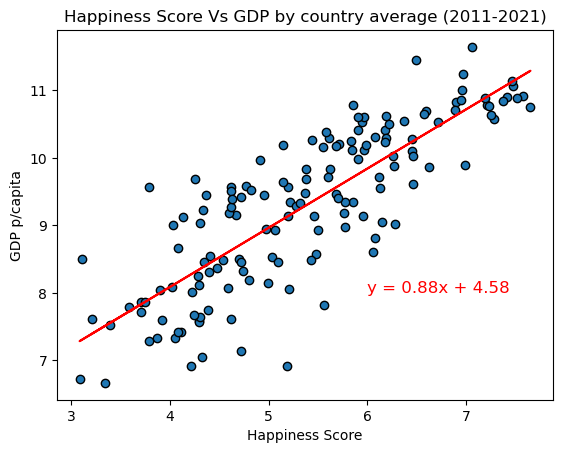

In [9]:
#plot correlation between GDP and happiness score - average of all countries (2012-2022)

#define x and y for plotting 
x = grouped_by_country["Happiness Score"]
y = grouped_by_country["GDP p/capita"]

#plot regression line 
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
plt.scatter(x, y, edgecolor='black')
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq, (6, 8), fontsize=12, color='red')
plt.xlabel("Happiness Score")
plt.ylabel("GDP p/capita")
plt.title("Happiness Score Vs GDP by country average (2011-2021)")    
    
print(f'The r-value is: {rvalue}')
print(f'The r-square vale is: {rvalue **2}')
plt.show()

## Healthy Life Expectancy Vs Happiness Score

The r-value is: 0.7962789341163949
The r-square vale is: 0.634060140917542


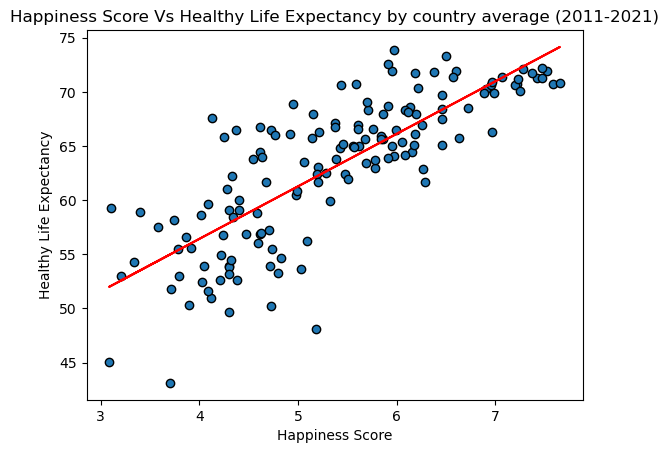

In [10]:
#plot correlation between GDP and happiness score - average of all countries (2012-2022)

#define x and y for plotting 
x = grouped_by_country["Happiness Score"]
y = grouped_by_country["Healthy Life Expectancy"]

#plot regression line 
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
plt.scatter(x, y, edgecolor='black')
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq, (6, 8), fontsize=12, color='red')

plt.xlabel("Happiness Score")
plt.ylabel("Healthy Life Expectancy")
plt.title("Happiness Score Vs Healthy Life Expectancy by country average (2011-2021)")    
    
print(f'The r-value is: {rvalue}')
print(f'The r-square vale is: {rvalue **2}')
plt.show()

## Corruption Perception Vs Happiness Score

The r-value is: -0.4124914759598624
The r-square vale is: 0.17014921773954575


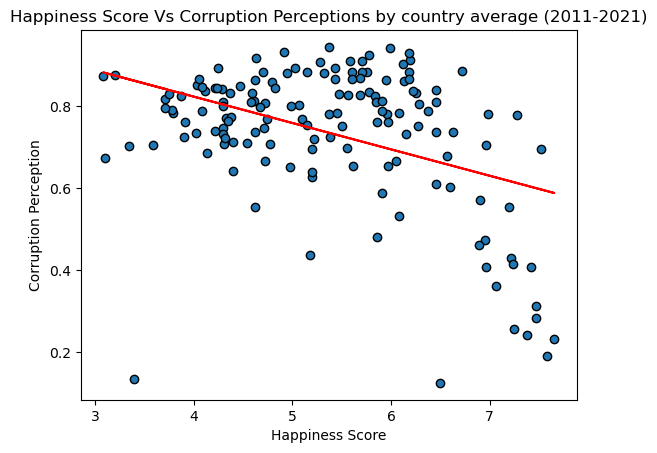

In [11]:
#correlation between corruption perception and happiness scores
x = grouped_by_country["Happiness Score"]
y = grouped_by_country["Corruption Perceptions"]

#plot regression line 
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
plt.scatter(x, y, edgecolor='black')
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq, (6, 8), fontsize=12, color='red')

plt.xlabel("Happiness Score")
plt.ylabel("Corruption Perception")
plt.title("Happiness Score Vs Corruption Perceptions by country average (2011-2021)")    
    
print(f'The r-value is: {rvalue}')
print(f'The r-square vale is: {rvalue **2}')
plt.show()

## Social Support Vs Happiness Score

The r-value is: 0.8023976136180975
The r-square vale is: 0.6438419303400177


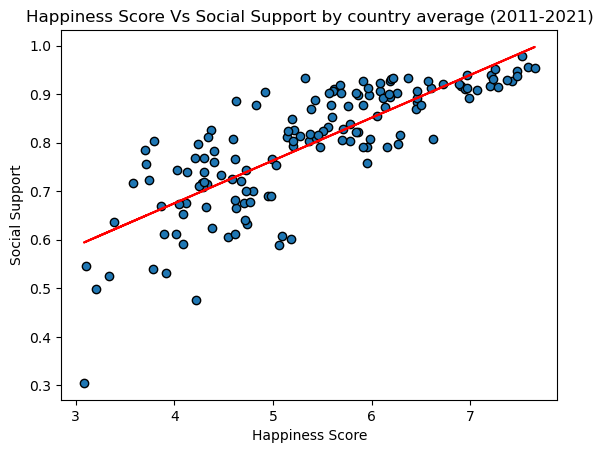

In [12]:
#correlation between happiness score and social support 
x = grouped_by_country["Happiness Score"]
y = grouped_by_country["Social Support"]

#plot regression line 
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
plt.scatter(x, y, edgecolor='black')
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq, (6, 8), fontsize=12, color='red')

plt.xlabel("Happiness Score")
plt.ylabel("Social Support")
plt.title("Happiness Score Vs Social Support by country average (2011-2021)")    
    
print(f'The r-value is: {rvalue}')
print(f'The r-square vale is: {rvalue **2}')
plt.show()

## GDP p/capita vs Happiness Score - 2021

NameError: name 'summary_GDP_df' is not defined

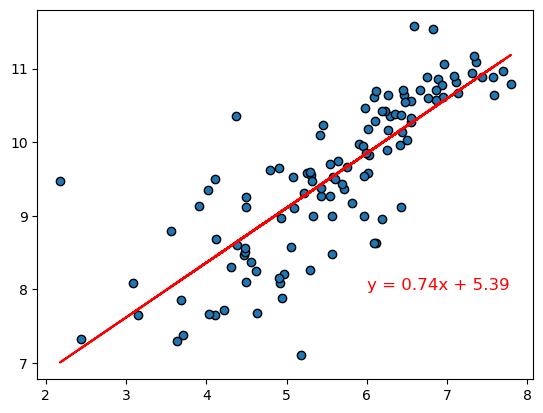

In [13]:
 # add linear regression
df_2022 = whr_clean_df[(whr_clean_df["Year"] == 2021)]   

#define x and y for plotting 
x = df_2022["Happiness Score"]
y = df_2022["GDP p/capita"]

#plot regression line 
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
plt.scatter(x, y, edgecolor='black')
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq, (6, 8), fontsize=12, color='red')
plt.axhline(summary_GDP_df.iloc[10, 1], color="red", linestyle="--")
plt.xlabel("Happiness Score")
plt.ylabel("GDP p/capita")
plt.title("Happiness Score Vs GDP per/capita (2021)")    
    
print(f'The r-value is: {rvalue}')
print(f'The r-square vale is: {rvalue **2}')
plt.show()

In [ ]:
#generate 10 graphs using for loop and subplots
# define function to loop through 
# def plot_yearly_data(df, year, ax):
#     df_year = whr_clean_df[whr_clean_df["Year"] == year]
    
    
#     x = df_year["Happiness Score"]
#     y = df_year["GDP p/capita"]
    
#     (slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
#     regress_value = x * slope + intercept
#     line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
    
#     ax.scatter(x, y, edgecolor="black")
#     ax.plot(x, regress_value, "r-")
#     ax.annotate(line_eq, (6, 8), fontsize=12, color="red")
#     ax.set_xlabel("Happiness Score")
#     ax.set_ylabel("GDP p/capita")
#     ax.set_title(f"Happiness Score Vs GDP per/ capital ({year})")
    
#     # print(f"Year {year} - The r-value is: {rvalue}")
#     # print(f"Year {year} - The r-square value is: {rvalue **2}")



In [ ]:
# # create list to hold years
# years = whr_clean_df["Year"].unique()
# #create grid of subplots
# fig, axs = plt.subplots(6, 2, figsize=(15, 25))

# #flatten
# axs = axs.flatten()

# #loop through each year 

# for i, year in enumerate(years):
#     plot_yearly_data(whr_clean_df, year, axs[i])

# # plt.tight_layout()
# # plt.show


# Summary Statistics Tables

In [14]:
#Sumary statistics for happiness score

summary_happiness_df = whr_clean_df.groupby(["Year"])["Happiness Score"].agg(["mean", "median", "var", "std", "sem"])
summary_happiness_df = pd.DataFrame(summary_happiness_df)
summary_happiness_df.columns = ["Mean Happiness", "Median Happiness", "Var Happiness", "Std Happiness", "Sem Happiness"]

#Sumary statistics for GDP
summary_GDP_df = whr_clean_df.groupby(["Year"])["GDP p/capita"].agg(["mean", "median", "var", "std", "sem"])
summary_GDP_df = pd.DataFrame(summary_GDP_df)
summary_GDP_df.columns = ["Mean GDP", "Median GDP", "Var GDP", "Std GDP", "Sem GDP"]

#Sumary statistics for Social Support
summary_Social_df = whr_clean_df.groupby(["Year"])["Social Support"].agg(["mean", "median", "var", "std", "sem"])
summary_Social_df = pd.DataFrame(summary_Social_df)
summary_Social_df.columns = ["Mean SS", "Median SS", "Var SS", "Std SS", "Sem SS"]

#Sumary statistics for Healthy Life Expectancy
summary_Healthy_df = whr_clean_df.groupby(["Year"])["Healthy Life Expectancy"].agg(["mean", "median", "var", "std", "sem"])
summary_Healthy_df = pd.DataFrame(summary_Healthy_df)
summary_Healthy_df.columns = ["Mean Healthy", "Median Healthy", "Var Healthy", "Std Healthy", "Sem Healthy"]



In [15]:

data_2019 = whr_clean_df[whr_clean_df["Year"] == 2019]["GDP p/capita"]
data_2020 = whr_clean_df[whr_clean_df["Year"] == 2020]["GDP p/capita"]

result = mannwhitneyu(data_2019, data_2020, alternative="two-sided")

U_statistic, p_value = result.statistic, result.pvalue

print(f"U-statistic: {U_statistic}")
print(f"P-value: {p_value}")


U-statistic: 6410.0
P-value: 0.3102529775970294


In [16]:
# summary stats for GDP p/capita 
summary_GDP_df = whr_clean_df.groupby(["Year"])["GDP p/capita"].agg(["mean", "median", "var", "std", "sem"])
summary_GDP_df = pd.DataFrame(summary_GDP_df)


The r-value is: 0.8027247124820208
The r-square vale is: 0.644366964029343


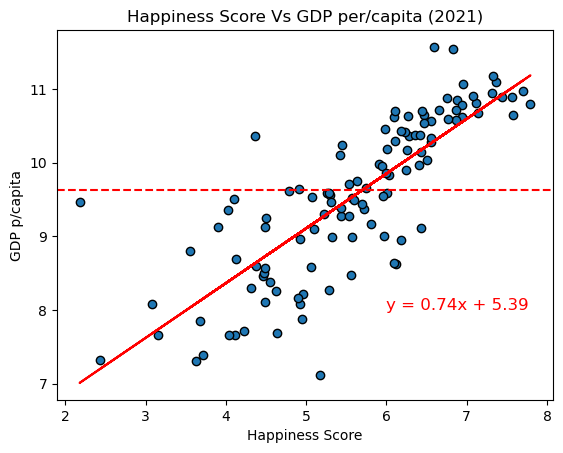

In [17]:
 # add linear regression
df_2022 = whr_clean_df[(whr_clean_df["Year"] == 2021)]   

#define x and y for plotting 
x = df_2022["Happiness Score"]
y = df_2022["GDP p/capita"]

#plot regression line 
(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
plt.scatter(x, y, edgecolor='black')
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq, (6, 8), fontsize=12, color='red')
plt.axhline(summary_GDP_df.iloc[10, 1], color="red", linestyle="--")
plt.xlabel("Happiness Score")
plt.ylabel("GDP p/capita")
plt.title("Happiness Score Vs GDP per/capita (2021)")    
    
print(f'The r-value is: {rvalue}')
print(f'The r-square vale is: {rvalue **2}')
plt.show()


In [18]:
# # compare Finland (top performer since 2016) to Lebanon (in the bottom 5 since 2016) 
# finland_df = whr_clean_df.loc[whr_clean_df["Country"] == "Finland"] #filter by Finland
# lebanon_df = whr_clean_df.loc[whr_clean_df["Country"] == "Lebanon"] #Filter by Lebanon
# australia_df = whr_clean_df.loc[whr_clean_df["Country"] == "Australia"] # Filter by Australia

# fig, axs = plt.subplots(1, 2, figsize=(15,6))

# #create First set of plots for each 
# axs[0].plot(finland_df["Year"], finland_df["Happiness Score"], label="Finland")
# axs[0].plot(lebanon_df["Year"], lebanon_df["Happiness Score"], label="Lebanon")
# axs[0].plot(australia_df["Year"], australia_df["Happiness Score"], label="Australia")

# #add lables to first plot etc 
# axs[0].set_title("Happiness Scores over time for Finland, Australia and Lebanon")
# axs[0].axhline(summary_happiness_df.iloc[10, 1], color="red", linestyle="--", label="Mean")
# axs[0].legend(loc="best")
# axs[0].set_xlabel("Year")
# axs[0].set_ylabel("Happiness Score")
                  
# #create second plot for GDP

# axs[1].plot(finland_df["Year"], finland_df["GDP p/capita"], label="Finland")
# axs[1].plot(lebanon_df["Year"], lebanon_df["GDP p/capita"], label="Lebanon")
# axs[1].plot(australia_df["Year"], australia_df["GDP p/capita"], label="Australia")

# axs[1].set_title("GDP p/capita over time for Finland, Australia and Lebanon")
# axs[1].axhline(summary_GDP_df.iloc[10, 1], color="red", linestyle="--", label="Mean")
# axs[1].legend(loc="best")
# axs[1].set_xlabel("Year")
# axs[1].set_ylabel("GDP p/capita")

# plt.tight_layout()
# plt.show()


In [19]:
#let's find happiest countries for each year

#create dictionaries to hold values of top and bottom scores for each year
top_df = pd.DataFrame()

#loop through years
for year in range(2016, 2023):
    year_df = whr_clean_df[whr_clean_df["Year"] == year] #filter data for the current year
    top1_df = year_df.nlargest(1, "Happiness Score") #find the top 5 countries with highest happiness scores for all years
    top_df = pd.concat([top1_df, top_df])
   


    
top_df.reset_index(drop=True, inplace=True)





In [20]:
# plot top 5 
# pivot_df = top_df.pivot(index="Year", columns="Country", values="Happiness Score")

# ax = pivot_df.plot(figsize=(10, 8), marker="o")

# plt.title("Fluctuation in Happiness Score for Top 5 Countries (2012-2022)")
# plt.xlabel("Year")
# plt.ylabel("Happiness Score")
# ax.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.grid(True)
# plt.tight_layout(rect=[0, 0.4, 0.85, 1])

# plt.show()



In [21]:
#let's find bottom 5 countries for each year

#create dictionaries to hold values of top and bottom scores for each year
bottom_df = pd.DataFrame()

#loop through years
for year in range(2016, 2023):
    year_df = whr_clean_df[whr_clean_df["Year"] == year] #filter data for the current year
    bottom1_df = year_df.nsmallest(1, "Happiness Score") #find the top 5 countries with highest happiness scores for all years
    bottom_df = pd.concat([bottom1_df, bottom_df])
   


    
bottom_df.reset_index(drop=True, inplace=True)


In [22]:
# #plot bottom countries 
# pivot_bottom_df = bottom_df.pivot(index="Year", columns="Country", values="Happiness Score")

# ax = pivot_bottom_df.plot(figsize=(10, 8), marker="o")

# plt.title("Fluctuation in Happiness Score for Bottom 5 Countries (2012-2022)")
# plt.xlabel("Year")
# plt.ylabel("Happiness Score")
# ax.legend(title="Country", bbox_to_anchor=(1.05, 1), loc="upper left")
# plt.grid(True)
# plt.tight_layout(rect=[0, 0.4, 0.85, 1])

# plt.show()


# Boxplots 

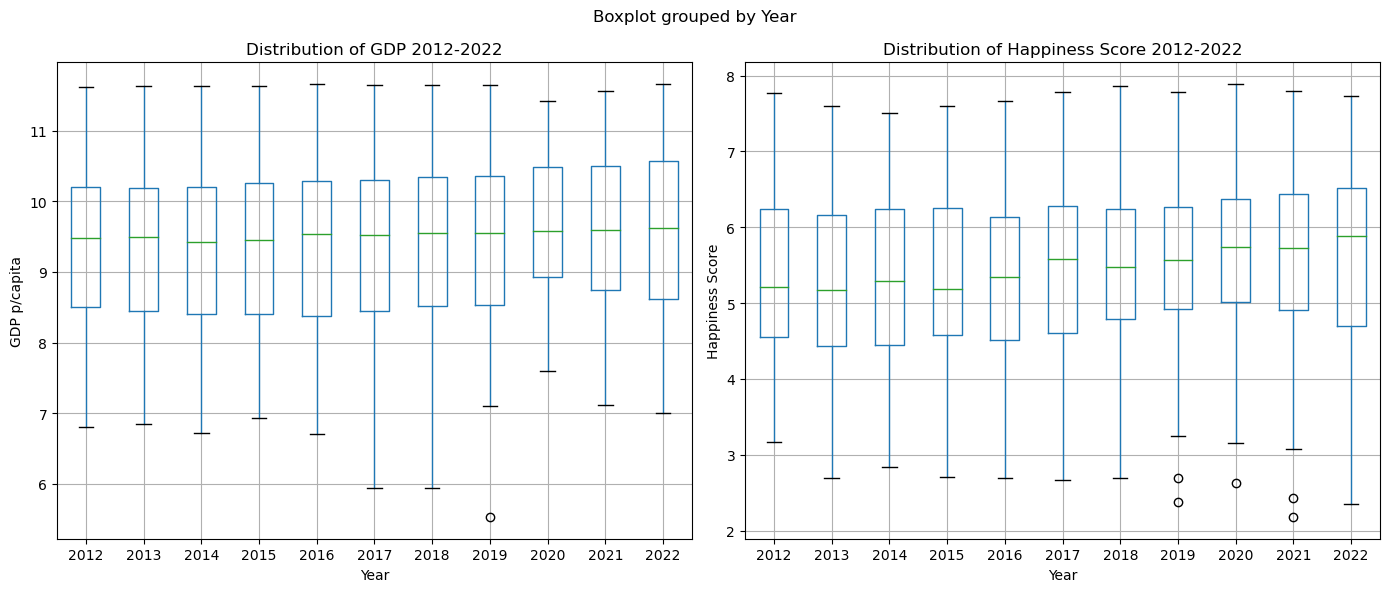

In [23]:
#Box plots GDP in all countries 
# making two fit into one fig

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

whr_clean_df.boxplot(column="GDP p/capita", by="Year", ax=axs[0])
axs[0].set_title("Distribution of GDP 2012-2022")
axs[0].set_ylabel("GDP p/capita")

whr_clean_df.boxplot(column="Happiness Score", by="Year", ax=axs[1])
axs[1].set_title("Distribution of Happiness Score 2012-2022")
axs[1].set_ylabel("Happiness Score")

plt.tight_layout()
plt.show()

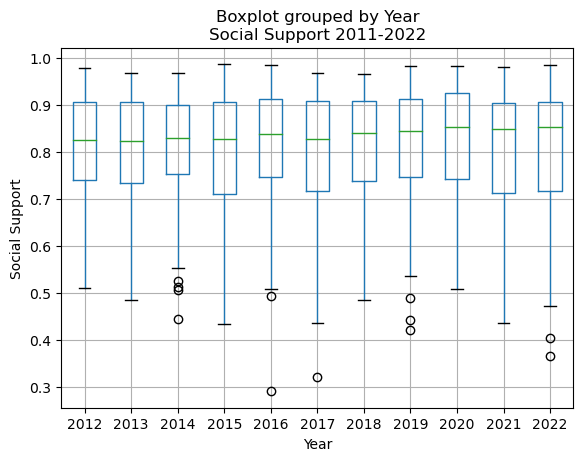

In [24]:
whr_clean_df.boxplot(column="Social Support", by="Year")
plt.title("Social Support 2011-2022")
plt.ylabel("Social Support")
plt.show()

## Find Outliers

In [25]:
#Find the outlier

for year in range(2012, 2023):
    year_GDP_df = whr_clean_df[whr_clean_df["Year"] == year]
    
    #Calculate the IQR and bounds for that year 
    
    quartiles = year_GDP_df["GDP p/capita"].quantile([.25, .5, .75])
    iqr = quartiles[.75] - quartiles[.25]
    u = quartiles[.75] + iqr*1.5
    l = quartiles[.25] - iqr*1.5
    
    #Id outliers
    outliers = year_GDP_df[(whr_clean_df["GDP p/capita"] > u)| (year_GDP_df["GDP p/capita"] < l)]["Country"]
    print(f"Outliers for year {year}:\n{outliers}")



Outliers for year 2012:
Series([], Name: Country, dtype: object)
Outliers for year 2013:
Series([], Name: Country, dtype: object)
Outliers for year 2014:
Series([], Name: Country, dtype: object)
Outliers for year 2015:
Series([], Name: Country, dtype: object)
Outliers for year 2016:
Series([], Name: Country, dtype: object)
Outliers for year 2017:
Series([], Name: Country, dtype: object)
Outliers for year 2018:
Series([], Name: Country, dtype: object)
Outliers for year 2019:
1443    Venezuela
Name: Country, dtype: object
Outliers for year 2020:
Series([], Name: Country, dtype: object)
Outliers for year 2021:
Series([], Name: Country, dtype: object)
Outliers for year 2022:
Series([], Name: Country, dtype: object)


In [26]:
#find the outliers for Happiness Score 
for year in range(2012, 2023):
    year_happy_df = whr_clean_df[whr_clean_df["Year"] == year]
    
    #Calculate the IQR and bounds for that year 
    
    quartiles =  year_happy_df["Happiness Score"].quantile([.25, .5, .75])
    iqr = quartiles[.75] - quartiles[.25]
    u = quartiles[.75] + iqr*1.5
    l = quartiles[.25] - iqr*1.5
    
    #Id outliers
    outliers = year_happy_df[(whr_clean_df["Happiness Score"] > u)| (year_happy_df["Happiness Score"] < l)]["Country"]
    print(f"Outliers for year {year}:\n{outliers}")

Outliers for year 2012:
Series([], Name: Country, dtype: object)
Outliers for year 2013:
Series([], Name: Country, dtype: object)
Outliers for year 2014:
Series([], Name: Country, dtype: object)
Outliers for year 2015:
Series([], Name: Country, dtype: object)
Outliers for year 2016:
Series([], Name: Country, dtype: object)
Outliers for year 2017:
Series([], Name: Country, dtype: object)
Outliers for year 2018:
Series([], Name: Country, dtype: object)
Outliers for year 2019:
7       Afghanistan
1483       Zimbabwe
Name: Country, dtype: object
Outliers for year 2020:
754    Lebanon
Name: Country, dtype: object
Outliers for year 2021:
8      Afghanistan
755        Lebanon
Name: Country, dtype: object
Outliers for year 2022:
Series([], Name: Country, dtype: object)


In [27]:
#let's find top richest 20 countries for each year

#create data frame to hold values
topGDP_df = pd.DataFrame()
bottomGDP_df = pd.DataFrame()


#loop through years
for year in range(2012, 2023):
    year_df = whr_clean_df[whr_clean_df["Year"] == year] #filter data for the current year
    top20_df = year_df.nlargest(20, "GDP p/capita") #find the top 20 countries with highest happiness scores for all years
    topGDP_df = pd.concat([top20_df, topGDP_df])
    bottom20_df = year_df.nsmallest(20, "GDP p/capita")
    bottomGDP_df = pd.concat([bottom20_df, bottomGDP_df])
    combined_top_bottom = pd.concat([topGDP_df, bottomGDP_df])
   
    
combined_top_bottom.reset_index(drop=True, inplace=True)
topGDP_df

,Country,Year,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
792,Luxembourg,2022,7.228,11.660,0.878,71.675,0.915,0.024,0.345,0.718,0.218
616,Ireland,2022,6.870,11.625,0.906,71.400,0.895,0.140,0.358,0.738,0.234
1274,Switzerland,2022,6.884,11.184,0.881,73.100,0.848,0.128,0.235,0.710,0.180
1017,Norway,2022,7.295,11.111,0.927,71.550,0.939,0.185,0.314,0.759,0.211
1413,United States,2022,6.693,11.079,0.900,65.725,0.736,0.191,0.701,0.712,0.267
...,...,...,...,...,...,...,...,...,...,...,...
419,Finland,2012,7.420,10.735,0.928,70.040,0.921,-0.005,0.361,0.742,0.202
430,France,2012,6.649,10.664,0.937,71.400,0.841,-0.153,0.608,0.705,0.253
1392,United Kingdom,2012,6.881,10.662,0.935,69.520,0.889,0.367,0.425,0.739,0.184
628,Italy,2012,5.839,10.633,0.869,71.300,0.570,0.109,0.908,0.651,0.388


In [28]:

top_2020 = topGDP_df[topGDP_df["Year"] == 2020]["GDP p/capita"]
bottom_2020 = bottomGDP_df[bottomGDP_df["Year"] == 2020]["GDP p/capita"]

result = mannwhitneyu(top_2020, bottom_2020, alternative="two-sided")

U_statistic, p_value = result.statistic, result.pvalue

print(f"U-statistic: {U_statistic}")
print(f"P-value: {p_value}")

U-statistic: 400.0
P-value: 6.786038616738627e-08


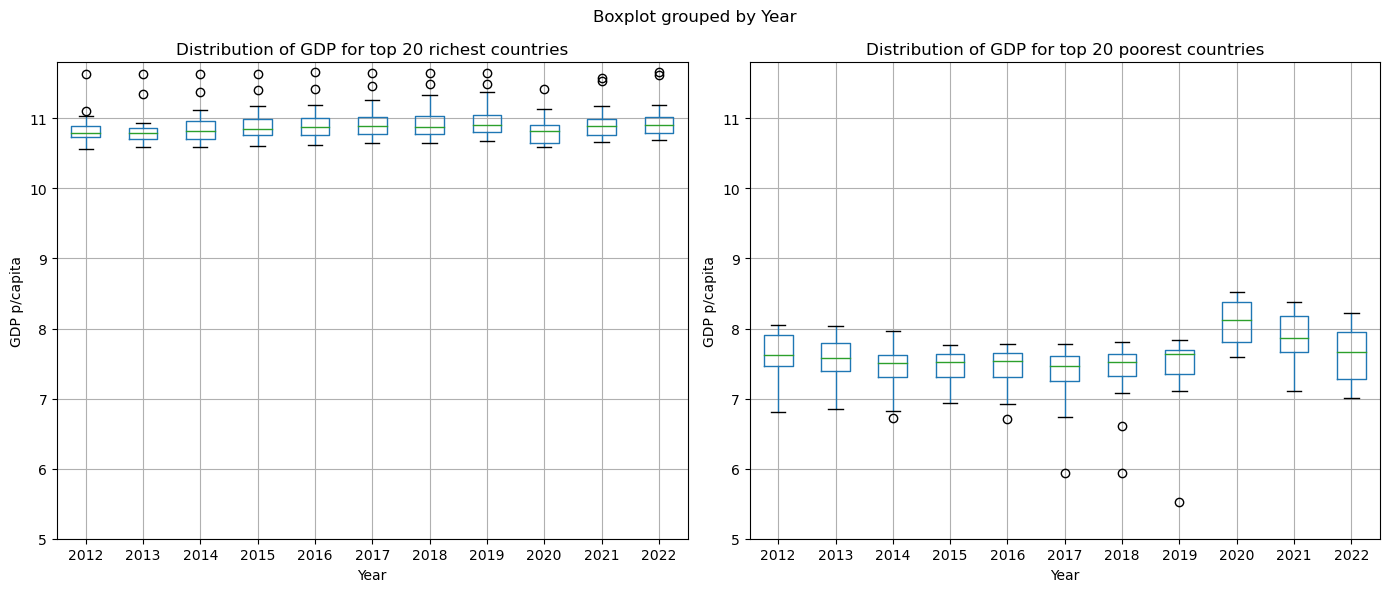

In [29]:
#GDP p/capita for top 20 richest countries in the world 

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

topGDP_df.boxplot(column="GDP p/capita", by="Year", ax=axs[0])
axs[0].set_title("Distribution of GDP for top 20 richest countries")
axs[0]. set_ylabel("GDP p/capita")

bottomGDP_df.boxplot(column="GDP p/capita", by="Year", ax=axs[1])
axs[1].set_title("Distribution of GDP for top 20 poorest countries")
axs[1]. set_ylabel("GDP p/capita")

axs[0].set_ylim(5, 11.8)
axs[1].set_ylim(5, 11.8)


plt.tight_layout()
plt.show()

#-----------------------------------------
# topGDP_df.boxplot(column="GDP p/capita", by="Year")
# bottomGDP_df.boxplot(column="GDP p/capita", by="Year")
# plt.title("Distribution of GDP for top 20 richest and poorest countries")
# plt.ylabel("GDP p/capita")


# plt.show()

#------------------------------------------


In [30]:
#create summary stats for top countries - GDP p/capita

summary_top = topGDP_df.groupby(["Year"])[["Happiness Score", "GDP p/capita", "Healthy Life Expectancy", "Social Support"]].mean()
summary_top

,Happiness Score,GDP p/capita,Healthy Life Expectancy,Social Support
Year,,,,
2012,7.06330,10.84305,70.11200,0.93365
2013,7.05490,10.83770,70.40900,0.92500
2014,7.01875,10.87745,70.76100,0.91840
2015,7.05870,10.91125,70.88000,0.93050
2016,7.06920,10.92545,70.86625,0.93350
2017,7.19285,10.94730,70.93500,0.93320
2018,7.16075,10.94945,71.01250,0.93030
2019,7.20380,10.97495,71.10500,0.93525
2020,7.05105,10.83835,71.30375,0.93170


# Top 20 GDP Vs Bottom 20 GDP

In [31]:
#create summary stats for bottom countries - GDP p/capita

summary_bottom = bottomGDP_df.groupby(["Year"])[["Happiness Score", "GDP p/capita", "Healthy Life Expectancy", "Social Support"]].mean()
summary_bottom

,Happiness Score,GDP p/capita,Healthy Life Expectancy,Social Support
Year,,,,
2012,4.02335,7.61225,53.40900,0.70355
2013,4.00225,7.57215,53.50500,0.70605
2014,3.95360,7.41945,53.50800,0.69975
2015,3.98855,7.43710,53.58000,0.66270
2016,3.89205,7.41885,54.11000,0.67030
2017,4.13270,7.34710,54.49500,0.64630
2018,4.20510,7.38315,55.57500,0.66530
2019,4.24890,7.43695,55.37500,0.68635
2020,4.77135,8.09125,58.02625,0.71330


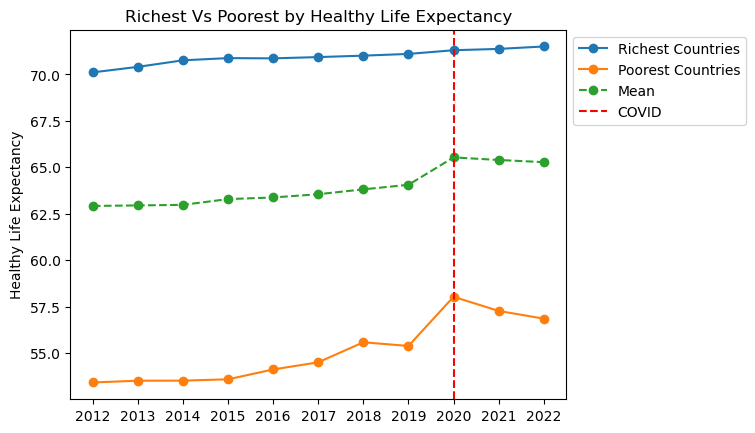

In [32]:
#plot healthy life expectancy for top 20 countries with highest GDP and 20 countries with lowest GDP 
plt.plot(summary_top.index, summary_top["Healthy Life Expectancy"], marker="o")
plt.plot(summary_bottom.index, summary_bottom["Healthy Life Expectancy"], marker="o")
plt.plot(grouped_clean_df.index, grouped_clean_df["Healthy Life Expectancy"], marker="o", linestyle="--")
plt.title("Richest Vs Poorest by Healthy Life Expectancy") 
plt.ylabel("Healthy Life Expectancy")
plt.axvline(2020, color="red", linestyle="--", label="COVID")
plt.legend(["Richest Countries", "Poorest Countries", "Mean", "COVID"], loc="upper left", bbox_to_anchor=(1, 1))

plt.xticks(summary_top.index)

plt.show()

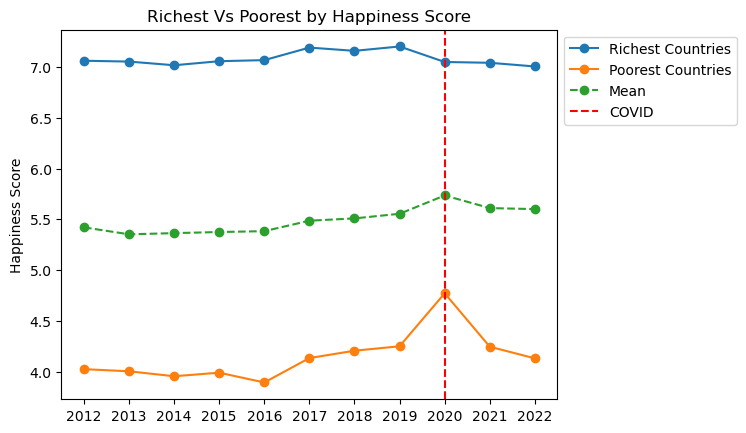

In [33]:
#plot the happiness score and the gdp trend 

# fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# axs[0].plot(summary_top.index, summary_top["Happiness Score"])
# axs[0].set_title("Average Happiness Score of Top GDP p/ capita Countries")
# axs[0].set_ylabel("Happiness Score")
# axs[0].set_xlabel("Years")

# axs[1].plot(summary_bottom.index, summary_bottom["Happiness Score"])
# axs[1].set_title("Average Happiness Score of Lowest GDP p/ capita Countries")
# axs[1].set_ylabel("Happiness Score")
# axs[1].set_xlabel("Years")


# plt.show()

plt.plot(summary_top.index, summary_top["Happiness Score"], marker="o")
plt.plot(summary_bottom.index, summary_bottom["Happiness Score"], marker="o")
plt.plot(grouped_clean_df.index, grouped_clean_df["Happiness Score"], marker="o", linestyle="--")
plt.title("Richest Vs Poorest by Happiness Score") 
plt.ylabel("Happiness Score")
plt.axvline(2020, color="red", linestyle="--", label="COVID")
plt.legend(["Richest Countries", "Poorest Countries", "Mean", "COVID"], loc="upper left", bbox_to_anchor=(1, 1))

plt.xticks(summary_top.index)

plt.show()

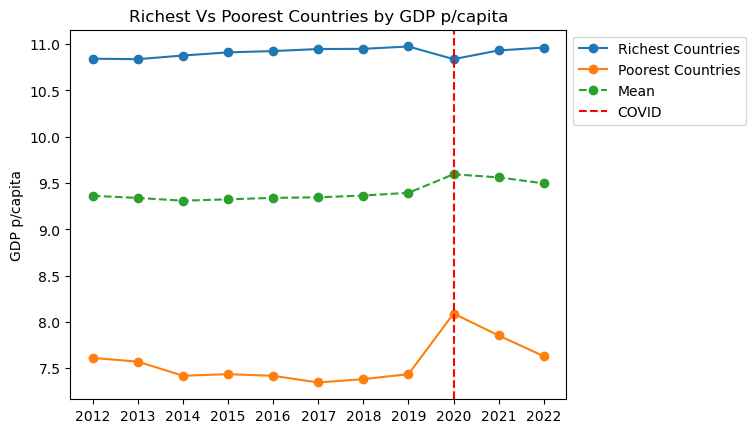

In [34]:
#plot the happiness score and the gdp trend 

# fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# axs[0].plot(summary_top.index, summary_top["GDP p/capita"])
# axs[0].set_title("Average GDP p/ capita for top 20 Countries")
# axs[0].set_ylabel("GDP p/capita")
# axs[0].set_xlabel("Years")

# axs[1].plot(summary_bottom.index, summary_bottom["Happiness Score"])
# axs[1].set_title("Average Happiness Score of Lowest GDP p/ capita Countries")
# axs[1].set_ylabel("Happiness Score")
# axs[1].set_xlabel("Years")

# plt.show()

plt.plot(summary_top.index, summary_top["GDP p/capita"], marker="o")
plt.plot(summary_bottom.index, summary_bottom["GDP p/capita"], marker="o")
plt.plot(grouped_clean_df.index, grouped_clean_df["GDP p/capita"], marker="o", linestyle="--")
plt.title("Richest Vs Poorest Countries by GDP p/capita") 
plt.ylabel("GDP p/capita")
plt.axvline(2020, color="red", linestyle="--", label="COVID")
plt.legend(["Richest Countries", "Poorest Countries", "Mean", "COVID"], loc="upper left", bbox_to_anchor=(1, 1))

plt.xticks(summary_top.index)

plt.show()

In [35]:



for year in range(2016, 2023):
    year_GDP_df = topGDP_df[topGDP_df["Year"] == year]
    
    #Calculate the IQR and bounds for that year 
    
    quartiles = year_GDP_df["GDP p/capita"].quantile([.25, .5, .75])
    iqr = quartiles[.75] - quartiles[.25]
    u = quartiles[.75] + iqr*1.5
    l = quartiles[.25] - iqr*1.5
    
    #Id outliers
    outliers = year_GDP_df[(year_GDP_df["GDP p/capita"] > u)| (year_GDP_df["GDP p/capita"] < l)][["Country", "Happiness Score", "GDP p/capita"]]
    
    # if not outliers.empty:
    print(f"Outliers for year {year}:\n{outliers}")


Outliers for year 2016:
         Country  Happiness Score  GDP p/capita
788   Luxembourg            6.967        11.664
1167   Singapore            6.033        11.420
Outliers for year 2017:
         Country  Happiness Score  GDP p/capita
789   Luxembourg            7.061        11.653
1168   Singapore            6.378        11.465
Outliers for year 2018:
         Country  Happiness Score  GDP p/capita
790   Luxembourg            7.243        11.645
1169   Singapore            6.375        11.496
Outliers for year 2019:
         Country  Happiness Score  GDP p/capita
791   Luxembourg            7.404        11.649
1170   Singapore            6.378        11.496
Outliers for year 2020:
     Country  Happiness Score  GDP p/capita
614  Ireland            7.035         11.42
Outliers for year 2021:
        Country  Happiness Score  GDP p/capita
1171  Singapore            6.587        11.571
615     Ireland            6.828        11.538
Outliers for year 2022:
        Country  Happiness 

The r-value is: 0.027579751082347243
The r-square vale is: 0.0007606426697642339


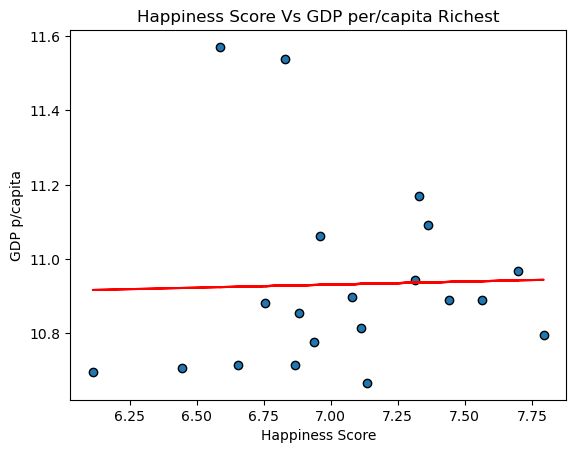

In [36]:
#is GDP related to greater happiness fo top 20 countries? 

topGDP_2022 = topGDP_df[topGDP_df["Year"] == 2021]

x = topGDP_2022["Happiness Score"]
y = topGDP_2022["GDP p/capita"]


(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
plt.scatter(x, y, edgecolor='black')
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq, (6, 8), fontsize=12, color='red')
plt.xlabel("Happiness Score")
plt.ylabel("GDP p/capita")
plt.title("Happiness Score Vs GDP per/capita Richest")    

print(f'The r-value is: {rvalue}')
print(f'The r-square vale is: {rvalue **2}')
plt.show()

The r-value is: 0.41323057086638515
The r-square vale is: 0.17075950469855855


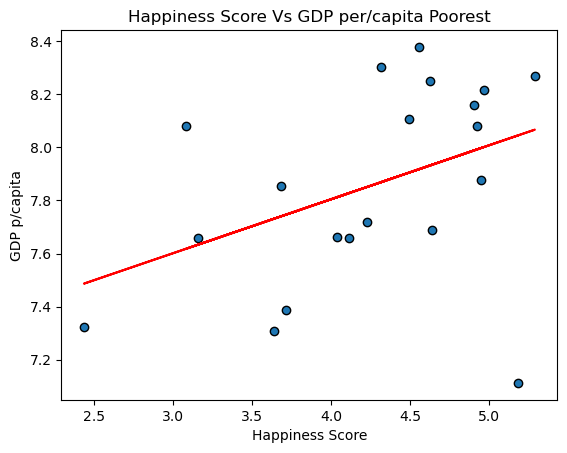

In [37]:
bottomGDP_2022 = bottomGDP_df[bottomGDP_df["Year"] == 2021]

x = bottomGDP_2022["Happiness Score"]
y = bottomGDP_2022["GDP p/capita"]


(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
plt.scatter(x, y, edgecolor='black')
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq, (6, 8), fontsize=12, color='red')
plt.xlabel("Happiness Score")
plt.ylabel("GDP p/capita")
plt.title("Happiness Score Vs GDP per/capita Poorest")    

print(f'The r-value is: {rvalue}')
print(f'The r-square vale is: {rvalue **2}')
plt.show()

# Graphs for Australia

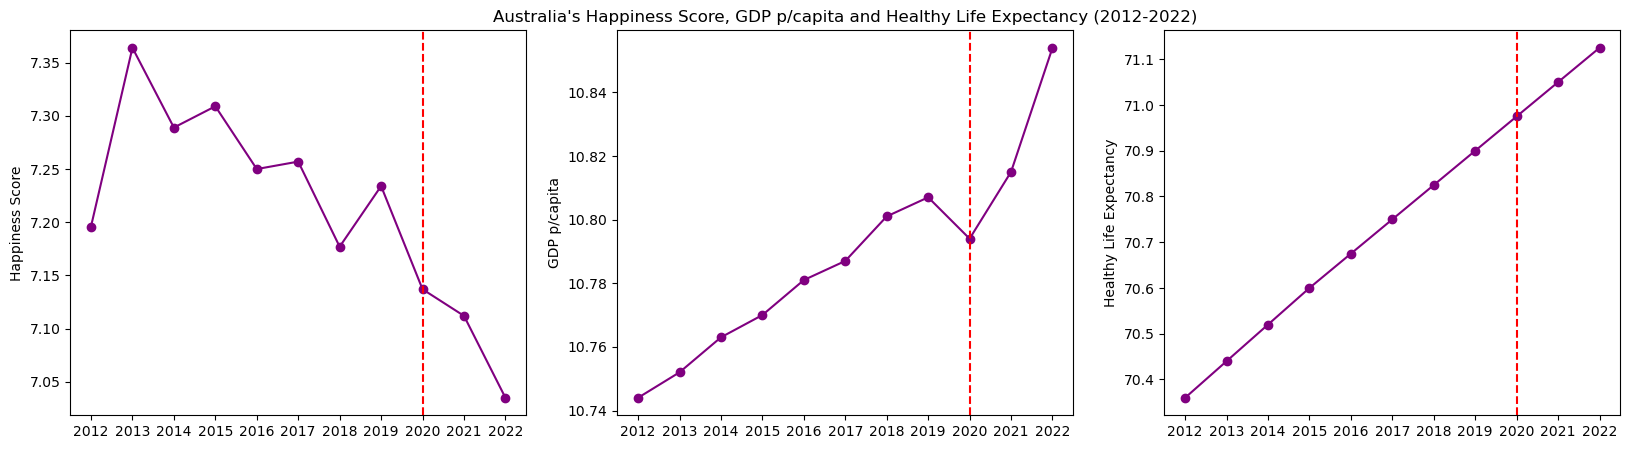

In [38]:
# filter by Australia
Aus_df = whr_clean_df.loc[whr_clean_df["Country"] == "Australia"]

fig, axs = plt.subplots(1, 3, figsize=(20, 5)) 

#plot hapiness score for australia

axs[0].plot(Aus_df["Year"], Aus_df["Happiness Score"], marker="o", color="purple")
axs[0].set_xticks(Aus_df["Year"])
axs[0].axvline(2020, linestyle="--", color="red")
axs[0].set_ylabel("Happiness Score")


#plot GDP score for australia
axs[1].plot(Aus_df["Year"], Aus_df["GDP p/capita"], marker="o", color="purple")
axs[1].set_xticks(Aus_df["Year"])
axs[1].set_title("Australia's Happiness Score, GDP p/capita and Healthy Life Expectancy (2012-2022)")
axs[1].axvline(2020, linestyle="--", color="red")
axs[1].set_ylabel("GDP p/capita")

#plot Healthy Life Expectancy score for australia
axs[2].plot(Aus_df["Year"], Aus_df["Healthy Life Expectancy"], marker="o", color="purple")
axs[2].set_xticks(Aus_df["Year"])
axs[2].axvline(2020, linestyle="--", color="red")
axs[2].set_ylabel("Healthy Life Expectancy")

plt.savefig("../Images/australia_combined.png")

plt.show()

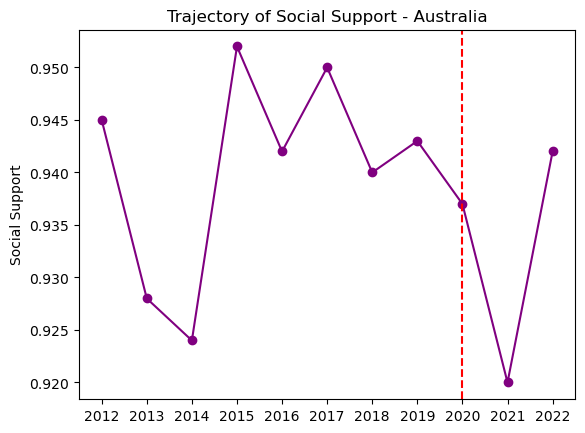

In [39]:
#plot Social Support for australia
plt.plot(Aus_df["Year"], Aus_df["Social Support"], marker="o", color="purple")
plt.xticks(Aus_df["Year"])
plt.axvline(2020, linestyle="--", color="red")
plt.ylabel("Social Support")
plt.title("Trajectory of Social Support - Australia")

plt.show()

# Graphs for all countries/ grouped by year 

In [40]:
#group by year the clean df
grouped_clean_df = whr_clean_df.groupby(["Year"]).mean()
grouped_clean_df

,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
Year,,,,,,,,,
2012,5.421103,9.362579,0.807563,62.916032,0.704889,-0.008595,0.761889,0.641476,0.263468
2013,5.352357,9.339524,0.804532,62.945873,0.728384,-0.003656,0.761770,0.655288,0.271540
2014,5.364062,9.309877,0.806892,62.975692,0.737677,0.019062,0.739315,0.658868,0.272015
2015,5.375070,9.324711,0.796031,63.286719,0.750391,0.016078,0.735211,0.658859,0.277352
2016,5.383480,9.340448,0.810376,63.373200,0.762720,0.000096,0.747152,0.658944,0.286904
2017,5.486492,9.346409,0.805515,63.549242,0.782674,-0.007273,0.728288,0.653765,0.290205
2018,5.509415,9.365685,0.809392,63.810962,0.780178,-0.027538,0.732508,0.653523,0.295115
2019,5.554725,9.394740,0.813191,64.056489,0.791654,-0.023831,0.723221,0.657160,0.289725
2020,5.735377,9.595406,0.824557,65.531604,0.808762,-0.004934,0.726953,0.665264,0.304462


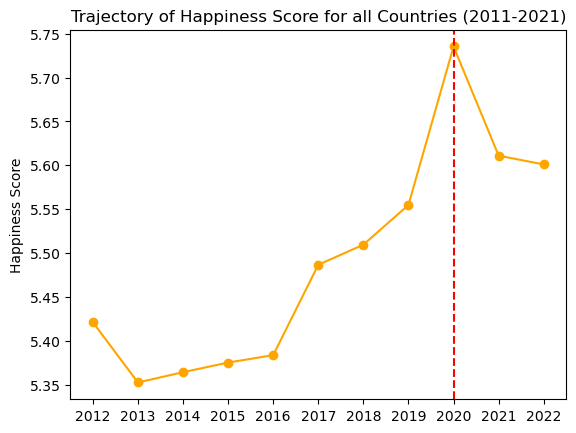

In [41]:
#plot hapiness score over time 2012-2022

plt.plot(grouped_clean_df.index, grouped_clean_df["Happiness Score"], marker="o", color="orange")
plt.ylabel("Happiness Score")
plt.title("Trajectory of Happiness Score for all Countries (2011-2021)")
plt.axvline(2020, color="red", linestyle="--", label="COVID")
plt.xticks(grouped_clean_df.index)
plt.savefig("../Images/happy_score_all_countries.png")

plt.show()

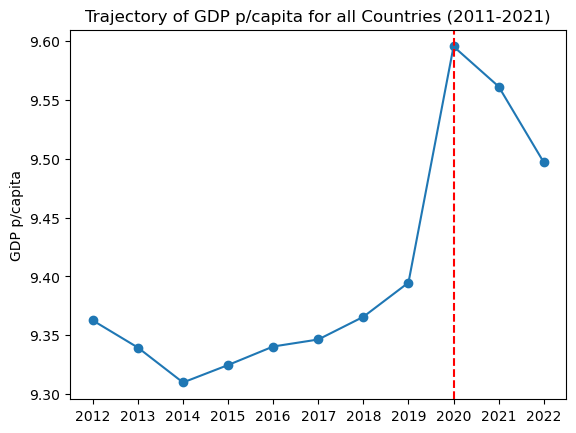

In [42]:
#plot GDP over time 2012-2022

plt.plot(grouped_clean_df.index, grouped_clean_df["GDP p/capita"], marker="o")
plt.ylabel("GDP p/capita")
plt.title("Trajectory of GDP p/capita for all Countries (2011-2021)")
plt.axvline(2020, color="red", linestyle="--", label="COVID")
plt.xticks(grouped_clean_df.index)
plt.savefig("../Images/GDP_all_countries.png")

plt.show()

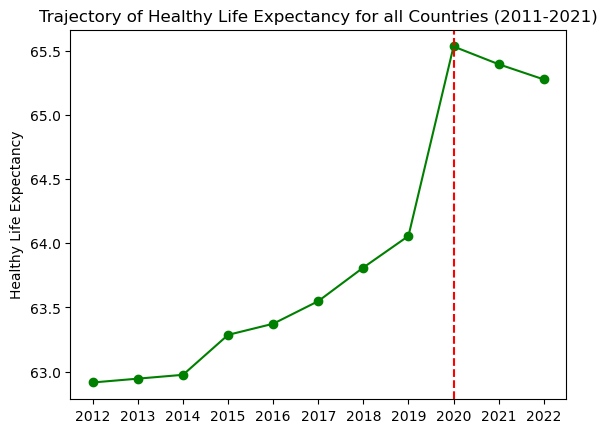

In [43]:
#plot Healthy Life Expectancy score over time 2012-2022
x_axis = grouped_clean_df.index
y_axis = grouped_clean_df["Healthy Life Expectancy"]
plt.plot(x_axis, y_axis, marker="o", color="green")
plt.axvline(2020, color="red", linestyle="--", label="COVID")
plt.xticks(grouped_clean_df.index)
plt.ylabel("Healthy Life Expectancy")
plt.title("Trajectory of Healthy Life Expectancy for all Countries (2011-2021)")
plt.savefig("../Images/healthy_life_expc_all_countries.png")
plt.show()

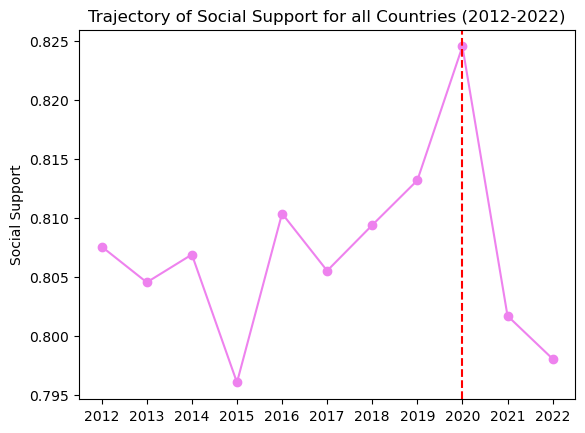

In [44]:
#plot Social support score over time 2011-2021
x_axis = grouped_clean_df.index
y_axis = grouped_clean_df["Social Support"]
plt.plot(x_axis, y_axis, marker="o", color="violet")
plt.axvline(2020, color="red", linestyle="--", label="COVID")
plt.xticks(grouped_clean_df.index)
plt.ylabel("Social Support")
plt.title("Trajectory of Social Support for all Countries (2012-2022)")
plt.show()


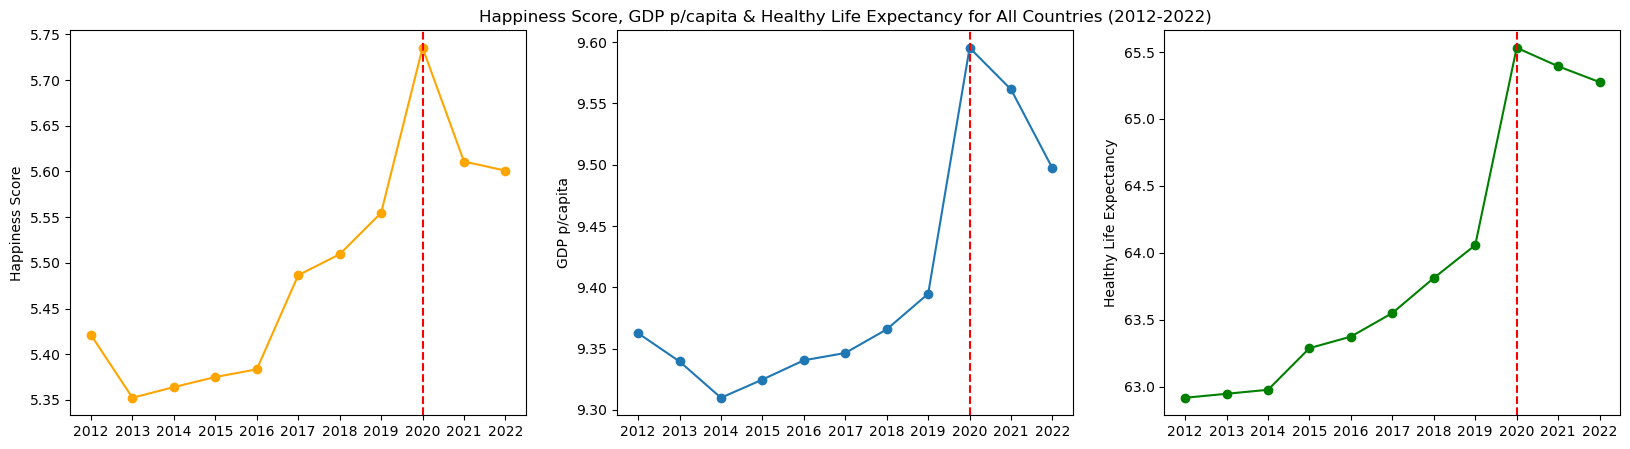

In [45]:
# fit all three previous graphs in one 

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

#first graph
axs[0].plot(grouped_clean_df.index, grouped_clean_df["Happiness Score"], marker="o", color="orange")
axs[0].set_ylabel("Happiness Score")

axs[0].axvline(2020, color="red", linestyle="--", label="COVID")
axs[0].set_xticks(grouped_clean_df.index)

#second graph
axs[1].plot(grouped_clean_df.index, grouped_clean_df["GDP p/capita"], marker="o")
axs[1].set_ylabel("GDP p/capita")
axs[1].set_title("Happiness Score, GDP p/capita & Healthy Life Expectancy for All Countries (2012-2022)")
axs[1].axvline(2020, color="red", linestyle="--", label="COVID")
axs[1].set_xticks(grouped_clean_df.index)

#third graph
x_axis = grouped_clean_df.index
y_axis = grouped_clean_df["Healthy Life Expectancy"]
axs[2].plot(x_axis, y_axis, marker="o", color="green")
axs[2].axvline(2020, color="red", linestyle="--", label="COVID")
axs[2].set_xticks(grouped_clean_df.index)
axs[2].set_ylabel("Healthy Life Expectancy")

plt.savefig("../Images/combined_all_countries.png")

plt.show()

In [46]:
# #plot GDP score over time 2016-2022
# x_axis = grouped_clean_df.index
# y_axis = grouped_clean_df["GDP p/capita"]
# plt.plot(x_axis, y_axis)
# plt.plot(grouped_clean_df.index, grouped_clean_df["Happiness Score"])
# plt.xticks(grouped_clean_df.index)
# plt.show()

The r-value is: 0.7097245346678838
The r-square vale is: 0.5037089151095442


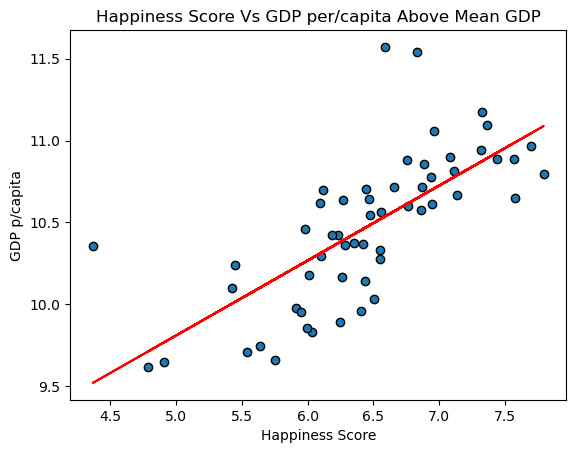

In [47]:
#identify trends for countries above GDP average and below 
above_mean = whr_clean_df[(whr_clean_df["Year"] == 2021) &
                         (whr_clean_df["GDP p/capita"] >=  9.608667)]

x = above_mean["Happiness Score"]
y = above_mean["GDP p/capita"]


(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
plt.scatter(x, y, edgecolor='black')
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq, (6, 8), fontsize=12, color='red')
plt.xlabel("Happiness Score")
plt.ylabel("GDP p/capita")
plt.title("Happiness Score Vs GDP per/capita Above Mean GDP")    

print(f'The r-value is: {rvalue}')
print(f'The r-square vale is: {rvalue **2}')
plt.show()

The r-value is: 0.4742155803151921
The r-square vale is: 0.22488041661367442


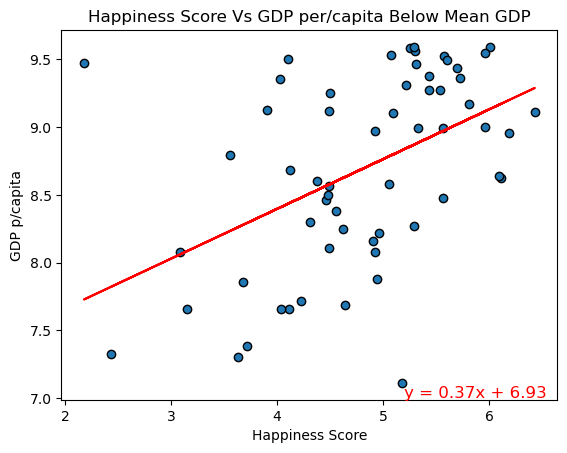

In [48]:
#identify trends for countries below GDP average and below 
below_mean = whr_clean_df[(whr_clean_df["Year"] == 2021) &
                         (whr_clean_df["GDP p/capita"] < 9.608667)]

x = below_mean["Happiness Score"]
y = below_mean["GDP p/capita"]


(slope, intercept, rvalue, pvalue, stderr) = linregress(x, y)
regress_values = x * slope + intercept
line_eq = f"y = {slope:.2f}x + {intercept:.2f}"
plt.scatter(x, y, edgecolor='black')
plt.plot(x,regress_values,"r-")
plt.annotate(line_eq, (5.2, 7), fontsize=12, color='red')
plt.xlabel("Happiness Score")
plt.ylabel("GDP p/capita")
plt.title("Happiness Score Vs GDP per/capita Below Mean GDP")    

print(f'The r-value is: {rvalue}')
print(f'The r-square vale is: {rvalue **2}')
plt.show()

In [49]:
#create a data frame filter only countries with the highest COVID deaths/ 100K POP.

top_covid_countries = ["Peru", "Bulgaria", "Hungary", "Bosnia and Herzegovina", 
                       "North Macedonia", "Montenegro", "Croatia", "Georgia", 
                       "Czechia", "Slovakia", "Poland", "Italy", "Lithuania", "Romania", 
                       "United States", "Slovenia", "Chile", "Greece", "Latvia", "Brazil", "United Kingdom"]

                         
                             
#create data frame to hold values

top_covid_df = pd.DataFrame()


#loop through top covid countries 
for country in top_covid_countries:
    top_covid = whr_clean_df[whr_clean_df["Country"] == country] #filter data coutry in list
    top_covid_df = pd.concat([top_covid, top_covid_df])

#create summary stats for top countries for ploting
summary_top_covid = top_covid_df.groupby(["Year"])[["Happiness Score", "GDP p/capita"]].mean()

summary_top_covid

,Happiness Score,GDP p/capita
Year,,
2012,5.618667,10.042381
2013,5.675619,10.057143
2014,5.763810,10.079143
2015,5.721333,10.106143
2016,5.815571,10.128048
2017,5.931714,10.161429
2018,6.016476,10.196571
2019,6.012350,10.205800
2020,6.111333,10.164286


In [50]:
#create a data frame filter only countries with the highest COVID deaths/ 100K POP.

bottom_covid_countries = ["Uzbekistan", "Ghana", "Nicaragua", "Mali", "Guinea",
                "Togo", "Ivory Coast", "Burkina Faso", "Congo (Kinshasa)", 
                "Sierra Leone", "Nigeria", "Tanzania", "Benin", 
                "Tajikistan", "Niger", "Chad", "Madagascar", "Liberia", "Ethiopia", "China"]

#create data frame to hold values

bottom_covid_df = pd.DataFrame()



#loop through bottom covid countries
for country in bottom_covid_countries:
    bottom_covid = whr_clean_df[whr_clean_df["Country"] == country] #filter data by country in list
    bottom_covid_df = pd.concat([bottom_covid, bottom_covid_df])

#create summary stats for bottom covid countries for ploting
summary_bottom_covid = bottom_covid_df.groupby(["Year"])[["Happiness Score", "GDP p/capita"]].mean()

summary_bottom_covid


,Happiness Score,GDP p/capita
Year,,
2012,4.403929,7.762429
2013,4.290118,7.778353
2014,4.138667,7.727500
2015,4.295684,7.778263
2016,4.269056,7.738056
2017,4.823684,7.817105
2018,4.859389,7.885722
2019,4.772778,7.905056
2020,5.017083,8.171500


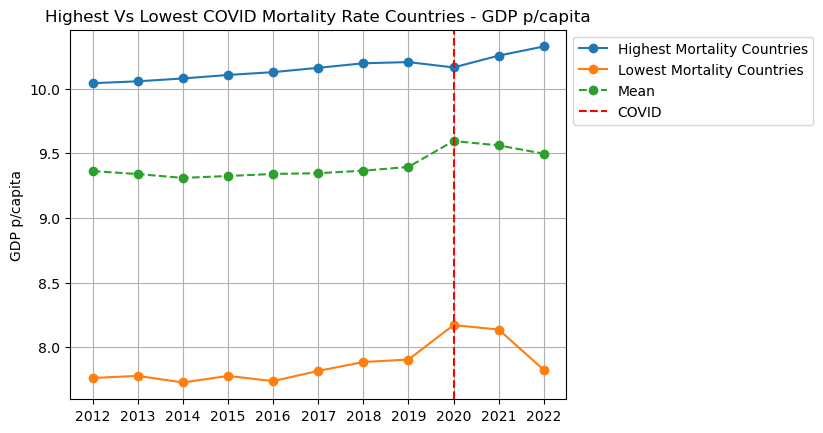

In [51]:
#plot in same plot the trajectory of Happiness Index for top and bottom covid countries 

plt.plot(summary_top_covid.index, summary_top_covid["GDP p/capita"], marker="o")
plt.plot(summary_bottom_covid.index, summary_bottom_covid["GDP p/capita"], marker="o")
plt.plot(grouped_clean_df.index, grouped_clean_df["GDP p/capita"], marker="o", linestyle="--")
plt.title("Highest Vs Lowest COVID Mortality Rate Countries - GDP p/capita") 
plt.ylabel("GDP p/capita")
plt.axvline(2020, color="red", linestyle="--", label="COVID")
plt.legend(["Highest Mortality Countries", "Lowest Mortality Countries", "Mean", "COVID"], loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(summary_top_covid.index)

plt.savefig("../Images/high_low_mortality_GDP.png")
plt.show()

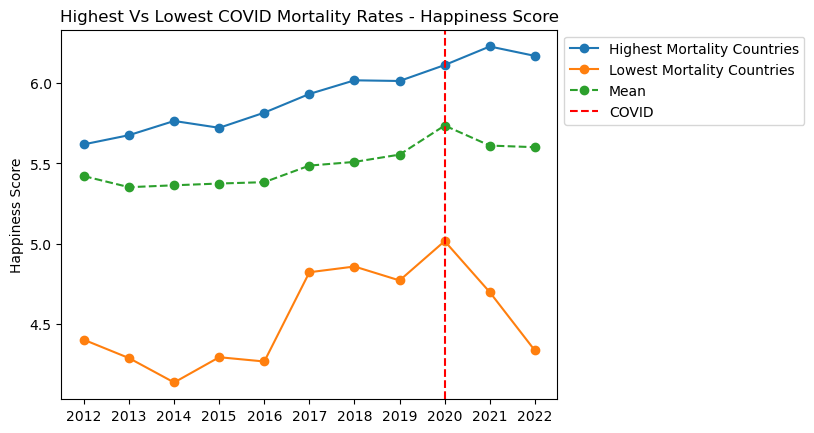

In [52]:
#plot in same plot the trajectory of Happiness Index for top and bottom covid countries 

plt.plot(summary_top_covid.index, summary_top_covid["Happiness Score"], marker="o")
plt.plot(summary_bottom_covid.index, summary_bottom_covid["Happiness Score"], marker="o")
plt.plot(grouped_clean_df.index, grouped_clean_df["Happiness Score"], marker="o", linestyle="--")
plt.title("Highest Vs Lowest COVID Mortality Rates - Happiness Score") 
plt.ylabel("Happiness Score")
plt.axvline(2020, color="red", linestyle="--", label="COVID")
plt.legend(["Highest Mortality Countries", "Lowest Mortality Countries", "Mean", "COVID"], loc="upper left", bbox_to_anchor=(1, 1))
plt.xticks(summary_top_covid.index)

plt.savefig("../Images/high_low_mortality_happy_score.png")

plt.show()

In [53]:
#create separate data frames for countries that sit above and below the GDP mean 

above_mean_gdp = pd.DataFrame()
below_mean_gdp = pd.DataFrame()


#loop through bottom covid countries
for year in range (2012, 2023):
    mean_gdp_for_year = grouped_clean_df.loc[year, "GDP p/capita"]
    above_mean = whr_clean_df[(whr_clean_df["Year"] == year) &
                              (whr_clean_df["GDP p/capita"] >= mean_gdp_for_year)]
    below_mean = whr_clean_df[(whr_clean_df["Year"] == year) &
                              (whr_clean_df["GDP p/capita"] < mean_gdp_for_year)]
    #concat iterations 
    above_mean_gdp = pd.concat([above_mean, above_mean_gdp])
    above_mean_gdp = above_mean_gdp.reset_index(drop=True)
    below_mean_gdp = pd.concat([below_mean, below_mean_gdp])
    below_mean_gdp = below_mean_gdp.reset_index(drop=True)

#create summary stats for above and below mean countries 
summary_above_gdp = above_mean_gdp.groupby(["Year"])[["Happiness Score", "GDP p/capita", "Healthy Life Expectancy"]].mean()
summary_below_gdp = below_mean_gdp.groupby(["Year"])[["Happiness Score", "GDP p/capita", "Healthy Life Expectancy"]].mean()

summary_below_gdp

,Happiness Score,GDP p/capita,Healthy Life Expectancy
Year,,,
2012,4.650450,8.397250,58.347000
2013,4.510589,8.299143,57.668214
2014,4.515946,8.195054,57.204286
2015,4.556018,8.190286,57.517857
2016,4.509833,8.165481,57.416204
2017,4.701339,8.154161,57.683929
2018,4.762179,8.197661,58.433482
2019,4.795018,8.255351,58.863158
2020,5.033704,8.786944,61.804630


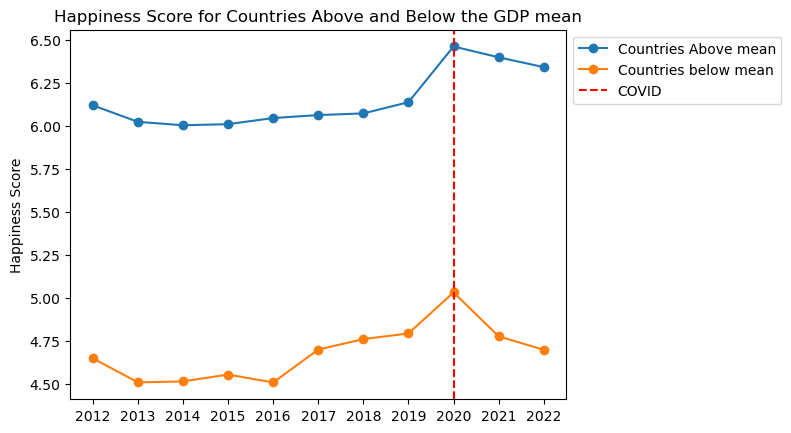

In [54]:
#plot trajectory of happiness score for coutnries above and below the gdp mean 

plt.plot(summary_above_gdp.index, summary_above_gdp["Happiness Score"], marker="o")
plt.plot(summary_below_gdp.index, summary_below_gdp["Happiness Score"], marker="o")
plt.xticks(summary_above_gdp.index)
plt.axvline(2020, color="red", linestyle="--", label="COVID")
plt.title("Happiness Score for Countries Above and Below the GDP mean") 
plt.ylabel("Happiness Score")
plt.legend(["Countries Above mean", "Countries below mean", "COVID"], loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig("../Images/below_above_happy_score.png")

plt.show()

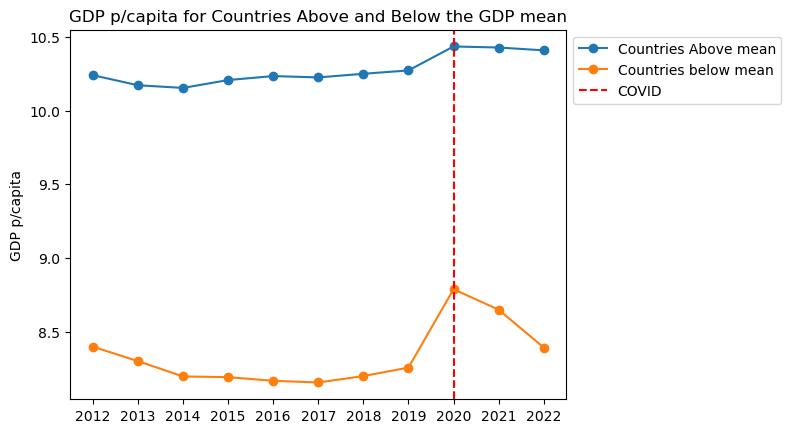

In [55]:
#plot trajectory of GDP for coutnries above and below the gdp mean 

plt.plot(summary_above_gdp.index, summary_above_gdp["GDP p/capita"], marker="o")
plt.plot(summary_below_gdp.index, summary_below_gdp["GDP p/capita"], marker="o")
plt.xticks(summary_above_gdp.index)
plt.axvline(2020, color="red", linestyle="--", label="COVID")
plt.title("GDP p/capita for Countries Above and Below the GDP mean") 
plt.ylabel("GDP p/capita")
plt.legend(["Countries Above mean", "Countries below mean", "COVID"], loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig("../Images/below_above_GDP.png")

plt.show()

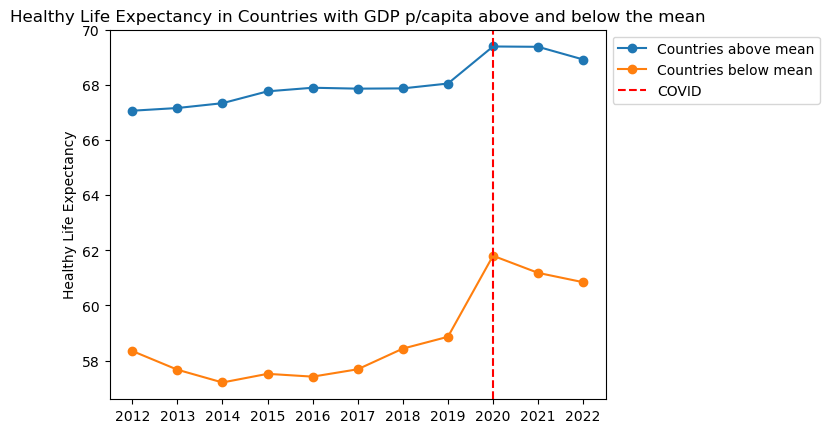

In [56]:
#plot trajectory of GDP for coutnries above and below the gdp mean

plt.plot(summary_above_gdp.index, summary_above_gdp["Healthy Life Expectancy"], marker="o")
plt.plot(summary_below_gdp.index, summary_below_gdp["Healthy Life Expectancy"], marker="o")
plt.xticks(summary_above_gdp.index)
plt.axvline(2020, color="red", linestyle="--", label="COVID")
plt.title("Healthy Life Expectancy in Countries with GDP p/capita above and below the mean") 
plt.ylabel("Healthy Life Expectancy")
plt.legend(["Countries above mean", "Countries below mean", "COVID"], loc="upper left", bbox_to_anchor=(1, 1))
plt.savefig("../Images/below_above_life_expec.png")

plt.show()


## Top 10 happiest Vs bottom 10 least happy

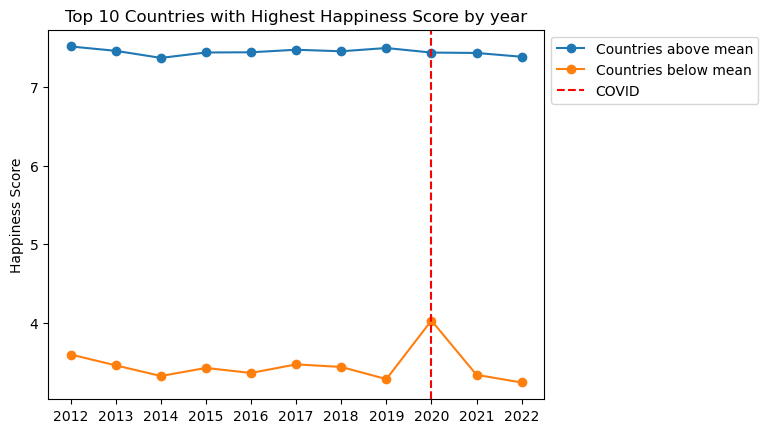

In [57]:
#dataframes 
happiest_grouped = happiest_df.groupby(["Year"])[["Happiness Score", "GDP p/capita", "Social Support", "Healthy Life Expectancy"]].mean()
least_happy_grouped = least_happy_df.groupby(["Year"])[["Happiness Score", "GDP p/capita", "Social Support", "Healthy Life Expectancy"]].mean()
#line plot for top and botom countries

plt.plot(happiest_grouped.index, happiest_grouped["Happiness Score"], marker="o")
plt.plot(least_happy_grouped.index, least_happy_grouped["Happiness Score"], marker="o")
plt.xticks(happiest_grouped.index)
plt.axvline(2020, color="red", linestyle="--", label="COVID")
plt.title("Top 10 Countries with Highest Happiness Score by year") 
plt.ylabel("Happiness Score")
plt.legend(["Countries above mean", "Countries below mean", "COVID"], loc="upper left", bbox_to_anchor=(1, 1))


plt.show()


In [58]:
happiest_grouped

,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy
Year,,,,
2012,7.5152,10.7617,0.9281,70.2260
2013,7.4597,10.6764,0.9196,70.3140
2014,7.3698,10.7088,0.9304,70.7460
2015,7.4388,10.8512,0.9459,71.0100
2016,7.4414,10.8667,0.9422,71.0975
2017,7.4737,10.8657,0.9431,71.2200
2018,7.4540,10.9737,0.9382,71.1025
2019,7.4956,11.0387,0.9445,71.6300
2020,7.4377,10.8850,0.9456,71.4275


In [59]:
least_happy_grouped

,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy
Year,,,,
2012,3.5961,7.7942,0.6123,55.4140
2013,3.4580,8.1209,0.6843,55.7360
2014,3.3224,7.6045,0.6402,53.4180
2015,3.4255,7.6872,0.6176,55.3600
2016,3.3612,7.7036,0.6301,53.7825
2017,3.4705,7.8435,0.6270,52.8850
2018,3.4378,7.8671,0.6347,56.2725
2019,3.2832,8.0002,0.6278,54.8500
2020,4.0287,8.3806,0.6630,58.7500


In [60]:
grouped_clean_df

,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
Year,,,,,,,,,
2012,5.421103,9.362579,0.807563,62.916032,0.704889,-0.008595,0.761889,0.641476,0.263468
2013,5.352357,9.339524,0.804532,62.945873,0.728384,-0.003656,0.761770,0.655288,0.271540
2014,5.364062,9.309877,0.806892,62.975692,0.737677,0.019062,0.739315,0.658868,0.272015
2015,5.375070,9.324711,0.796031,63.286719,0.750391,0.016078,0.735211,0.658859,0.277352
2016,5.383480,9.340448,0.810376,63.373200,0.762720,0.000096,0.747152,0.658944,0.286904
2017,5.486492,9.346409,0.805515,63.549242,0.782674,-0.007273,0.728288,0.653765,0.290205
2018,5.509415,9.365685,0.809392,63.810962,0.780178,-0.027538,0.732508,0.653523,0.295115
2019,5.554725,9.394740,0.813191,64.056489,0.791654,-0.023831,0.723221,0.657160,0.289725
2020,5.735377,9.595406,0.824557,65.531604,0.808762,-0.004934,0.726953,0.665264,0.304462


In [61]:
summary_happiness_df

,Mean Happiness,Median Happiness,Var Happiness,Std Happiness,Sem Happiness
Year,,,,,
2012,5.421103,5.2135,1.334655,1.155273,0.102920
2013,5.352357,5.1720,1.461557,1.208949,0.107702
2014,5.364062,5.2970,1.422436,1.192659,0.104603
2015,5.375070,5.1885,1.328168,1.152462,0.101864
2016,5.383480,5.3460,1.356665,1.164760,0.104179
2017,5.486492,5.5865,1.289063,1.135369,0.098821
2018,5.509415,5.4810,1.215559,1.102524,0.096698
2019,5.554725,5.5630,1.278624,1.130762,0.098795
2020,5.735377,5.7450,0.989733,0.994853,0.096629


In [67]:
# read the depression file 
depression_df = pd.read_csv("../Resources/depression-rates-by-country-2023.csv")
depression_df.head()

,country,prevalence,cases,pop2023
0,Ukraine,6.3,2800587,36744634.0
1,United States,5.9,17491047,339996563.0
2,Australia,5.9,1318599,26439111.0
3,Estonia,5.9,75667,1322765.0
4,Brazil,5.8,11548577,216422446.0


In [68]:
# rename columns 
depression_df.columns = ["Country", "% of Pop with Depression", "Cases", "Pop-2023"]
depression_df

,Country,% of Pop with Depression,Cases,Pop-2023
0,Ukraine,6.3,2800587,36744634.0
1,United States,5.9,17491047,339996563.0
2,Australia,5.9,1318599,26439111.0
3,Estonia,5.9,75667,1322765.0
4,Brazil,5.8,11548577,216422446.0
...,...,...,...,...
175,Kiribati,3.1,3452,133515.0
176,Micronesia,3.1,3182,115224.0
177,Papua New Guinea,3.0,223094,10329931.0
178,Timor-Leste,3.0,33932,1360596.0


In [62]:
# Python API
# Create a dataframe for the country and longitue/latitude
params = {
    "apiKey": geoapify_key
}

# Build URL using the geocode endpoint
base_url = "https://api.geoapify.com/v1/geocode/search"

country_data = []

country_list = whr_clean_df["Country"].unique()
print(f"There are {len(country_list)} countries in total.")

# Go through list of countries to get coordinates
for country in country_list:
    params["country"] = country
    
    # Run request
    response = requests.get(base_url, params=params).json()
    
    try:
        lat = response['features'][0]['properties']['lat']
        long = response['features'][0]['properties']['lon']
        a2code = response['features'][0]['properties']['country_code']
        country_py = pycountry.countries.get(alpha_2=a2code)
        a3code = country_py.alpha_3
    except:
        pass
        
    country_data.append({"Country": country,
                        "Latitude": lat,
                        "Longitude":long,
                        "Code_A3" : a3code.upper()})
    

country_df = pd.DataFrame(country_data)
country_df

There are 148 countries in total.


,Country,Latitude,Longitude,Code_A3
0,Afghanistan,33.768006,66.238514,AFG
1,Albania,41.000028,19.999962,ALB
2,Algeria,28.000027,2.999983,DZA
3,Angola,-11.877577,17.569124,AGO
4,Argentina,-34.996496,-64.967282,ARG
...,...,...,...,...
143,Venezuela,8.001871,-66.110932,VEN
144,Vietnam,15.926666,107.965086,VNM
145,Yemen,16.347124,47.891527,YEM
146,Zambia,-14.518912,27.558988,ZMB


In [63]:
#Show the participating countries
# Configure the map plot
country_map_plot = country_df.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "ESRI",
    frame_width = 800,
    frame_height = 600,
    #size = "Humidity",
    scale = 0.5,
    color = "Country"

)

# Display the map
country_map_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Country)

In [64]:
# Save original dataframe to a working dataframe
world_happiness_df = whr_clean_df
world_happiness_df

,Country,Year,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
0,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.238,0.776,0.614,0.268
1,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.063,0.823,0.547,0.273
2,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.106,0.871,0.492,0.375
3,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.082,0.881,0.491,0.339
4,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.044,0.793,0.501,0.348
...,...,...,...,...,...,...,...,...,...,...,...
1482,Zimbabwe,2018,3.616,7.783,0.775,52.625,0.763,-0.051,0.844,0.658,0.212
1483,Zimbabwe,2019,2.694,7.698,0.759,53.100,0.632,-0.047,0.831,0.658,0.235
1484,Zimbabwe,2020,3.160,7.596,0.717,53.575,0.643,0.006,0.789,0.661,0.346
1485,Zimbabwe,2021,3.155,7.657,0.685,54.050,0.668,-0.076,0.757,0.610,0.242


In [65]:
# Create Happiness average score per country
whr_clean_group_df = whr_clean_df.groupby("Country").mean()
# Merge the two DataFrames, WHR and Country coordinates, together based on the Country Name they share
merged_country_happiness_df = pd.merge(whr_clean_group_df, country_df, on=["Country"])
merged_country_happiness_df

,Country,Year,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect,Latitude,Longitude,Code_A3
0,Afghanistan,2016.111111,3.206222,7.617667,0.499111,52.977778,0.457667,0.015111,0.877333,0.440889,0.387556,33.768006,66.238514,AFG
1,Albania,2017.000000,4.951273,9.454273,0.690091,68.910909,0.739727,-0.052000,0.882000,0.560364,0.301545,41.000028,19.999962,ALB
2,Algeria,2017.833333,5.216167,9.339667,0.826167,66.283333,0.520667,-0.122167,0.721000,0.532500,0.266000,28.000027,2.999983,DZA
3,Angola,2013.000000,4.030667,8.999667,0.743333,52.460000,0.413667,-0.138333,0.852000,0.612000,0.348000,-11.877577,17.569124,AGO
4,Argentina,2017.000000,6.257545,10.034000,0.901273,66.961818,0.810909,-0.155727,0.833091,0.731727,0.298545,-34.996496,-64.967282,ARG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143,Venezuela,2015.500000,5.565500,7.821125,0.902000,64.911250,0.607375,-0.062875,0.827625,0.764500,0.295125,8.001871,-66.110932,VEN
144,Vietnam,2017.625000,5.456500,9.132000,0.816625,65.175000,0.918500,-0.062125,0.784125,0.639750,0.207500,15.926666,107.965086,VNM
145,Yemen,2015.166667,3.747500,7.861333,0.723667,58.177500,0.621167,-0.144833,0.830500,0.461000,0.275667,16.347124,47.891527,YEM
146,Zambia,2016.500000,4.299500,8.111700,0.719100,53.196500,0.794900,0.043900,0.800600,0.669500,0.346500,-14.518912,27.558988,ZMB


In [69]:
# Merge the two DataFrames, WHR with coordinates and Depression data, together based on the Country Name they share
#
# IMPORTANT NOTE: Depression rate was dated 2023 ???
#
happiness_depression_df = pd.merge(merged_country_happiness_df, depression_df, on=["Country"])
happiness_depression_df

,Country,Year,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect,Latitude,Longitude,Code_A3,% of Pop with Depression,Cases,Pop-2023
0,Afghanistan,2016.111111,3.206222,7.617667,0.499111,52.977778,0.457667,0.015111,0.877333,0.440889,0.387556,33.768006,66.238514,AFG,3.3,1038610,42239854.0
1,Albania,2017.000000,4.951273,9.454273,0.690091,68.910909,0.739727,-0.052000,0.882000,0.560364,0.301545,41.000028,19.999962,ALB,4.8,131048,2832439.0
2,Algeria,2017.833333,5.216167,9.339667,0.826167,66.283333,0.520667,-0.122167,0.721000,0.532500,0.266000,28.000027,2.999983,DZA,4.5,1683914,45606480.0
3,Angola,2013.000000,4.030667,8.999667,0.743333,52.460000,0.413667,-0.138333,0.852000,0.612000,0.348000,-11.877577,17.569124,AGO,3.6,892128,36684202.0
4,Argentina,2017.000000,6.257545,10.034000,0.901273,66.961818,0.810909,-0.155727,0.833091,0.731727,0.298545,-34.996496,-64.967282,ARG,4.7,1914354,45773884.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,Venezuela,2015.500000,5.565500,7.821125,0.902000,64.911250,0.607375,-0.062875,0.827625,0.764500,0.295125,8.001871,-66.110932,VEN,4.2,1270099,28838499.0
139,Vietnam,2017.625000,5.456500,9.132000,0.816625,65.175000,0.918500,-0.062125,0.784125,0.639750,0.207500,15.926666,107.965086,VNM,4.0,3564934,98858950.0
140,Yemen,2015.166667,3.747500,7.861333,0.723667,58.177500,0.621167,-0.144833,0.830500,0.461000,0.275667,16.347124,47.891527,YEM,3.6,915231,34449825.0
141,Zambia,2016.500000,4.299500,8.111700,0.719100,53.196500,0.794900,0.043900,0.800600,0.669500,0.346500,-14.518912,27.558988,ZMB,4.0,636819,20569737.0


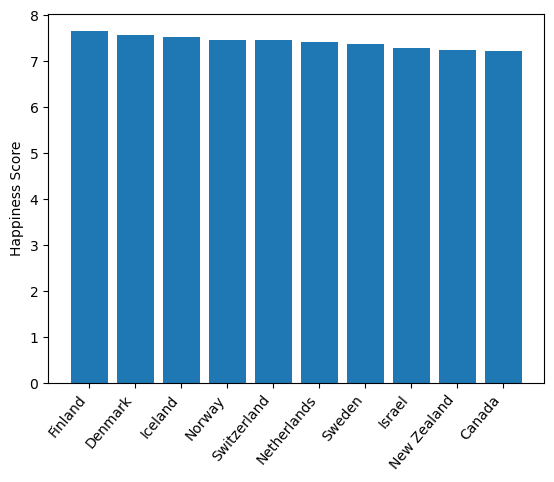

In [70]:
# Display top 10 countries with highest Happiness Score
happiness_depression_df = happiness_depression_df.sort_values("Happiness Score", ascending=False)
country_happiness_df = happiness_depression_df.iloc[0:10, :].set_index("Country")
x_axis = country_happiness_df.index
y_axis = country_happiness_df["Happiness Score"]
plt.bar(x_axis, y_axis)
plt.xticks(country_happiness_df.index, rotation=50, ha="right")
plt.ylabel("Happiness Score")
plt.show()


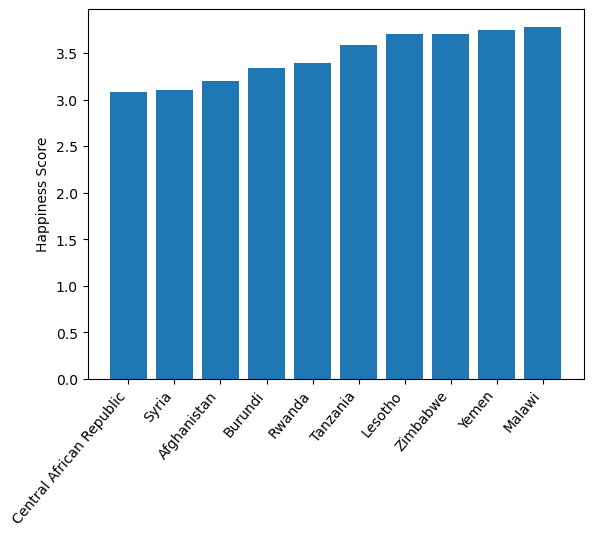

In [71]:
# Display top 10 countries with lowest Happiness Score
happiness_depression_df = happiness_depression_df.sort_values("Happiness Score")
country_happiness_df = happiness_depression_df.iloc[0:10, :].set_index("Country")
x_axis = country_happiness_df.index
y_axis = country_happiness_df["Happiness Score"]
plt.bar(x_axis, y_axis)
plt.xticks(country_happiness_df.index, rotation=50, ha="right")
plt.ylabel("Happiness Score")
plt.show()

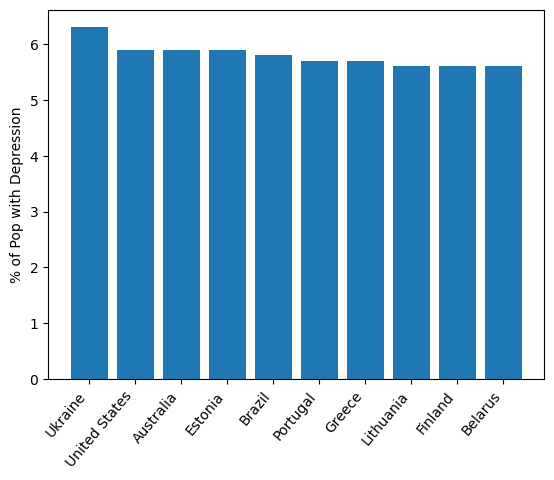

In [72]:
# Display top 5 countries with highest depression
happiness_depression_df = happiness_depression_df.sort_values("% of Pop with Depression", ascending=False)
country_depression_df = happiness_depression_df.iloc[0:10, :].set_index("Country")
x_axis = country_depression_df.index
y_axis = country_depression_df["% of Pop with Depression"]
plt.bar(x_axis, y_axis)
plt.xticks(country_depression_df.index, rotation=50, ha="right")
plt.ylabel("% of Pop with Depression")
plt.show()


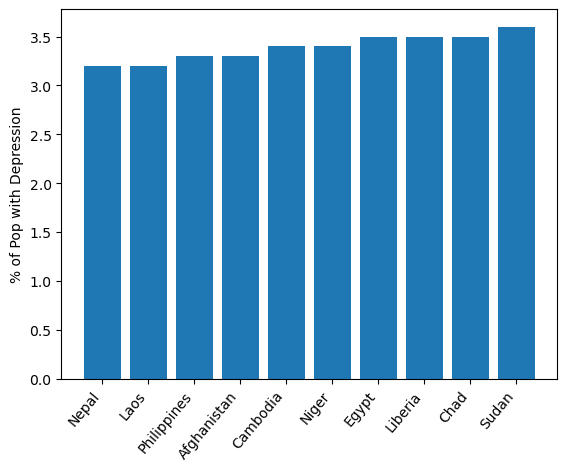

In [73]:
# Display top 5 countries with lowest depression
happiness_depression_df = happiness_depression_df.sort_values("% of Pop with Depression")
country_depression_df = happiness_depression_df.iloc[0:10, :].set_index("Country")
x_axis = country_depression_df.index
y_axis = country_depression_df["% of Pop with Depression"]
plt.bar(x_axis, y_axis)
plt.xticks(country_depression_df.index, rotation=50, ha="right")
plt.ylabel("% of Pop with Depression")
plt.show()


# Show plot based on lacation and the happiness score/% of population with depression (side by side) marked by color intensity

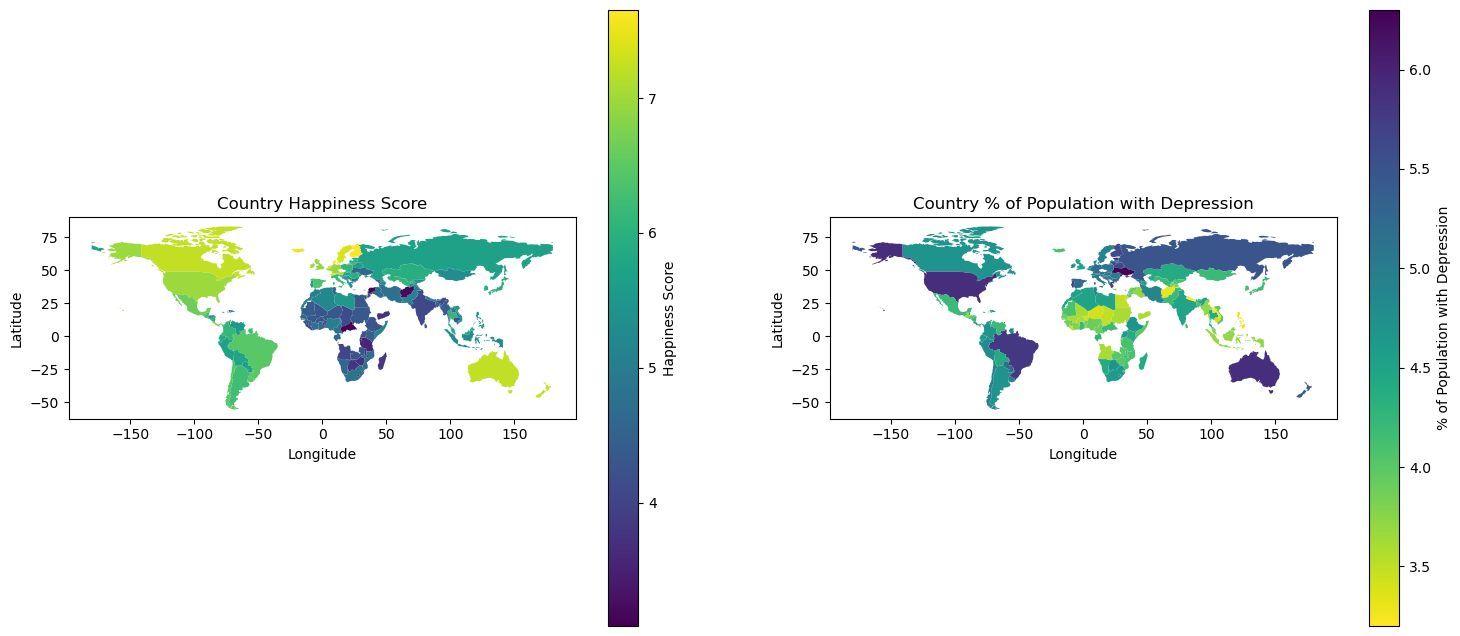

In [103]:

# Read country map images
world_maps = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge your data with the map data
world_happiness_merged = world_maps.merge(happiness_depression_df, left_on='iso_a3', right_on='Code_A3')

# Plot the map with colored tiles
fig, ax = plt.subplots(1, 2, figsize=(18, 8))

world_happiness_merged.plot(column='Happiness Score', cmap='viridis', linewidth=0.4, ax=ax[0], legend=True, legend_kwds={'label': "Happiness Score"})
ax[0].set_title('Country Happiness Score')
ax[0].set_ylabel("Latitude")
ax[0].set_xlabel("Longitude")

# world_happiness_merged contains depression data too
world_depression_merged = world_happiness_merged


# getting the original colormap using cm.get_cmap() function
orig_map=plt.cm.get_cmap('viridis')
  
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

world_depression_merged.plot(column='% of Pop with Depression', cmap=reversed_map, linewidth=0.4, ax=ax[1], legend=True, legend_kwds={'label': "% of Population with Depression"})
ax[1].set_title('Country % of Population with Depression')
ax[1].set_ylabel("Latitude")
ax[1].set_xlabel("Longitude")

plt.savefig(f"../Images/Happiness-Depression Heat Map (side by side).png", bbox_inches="tight")
    
plt.show()

# Show plot based on lacation and the happiness score marked by color intensity

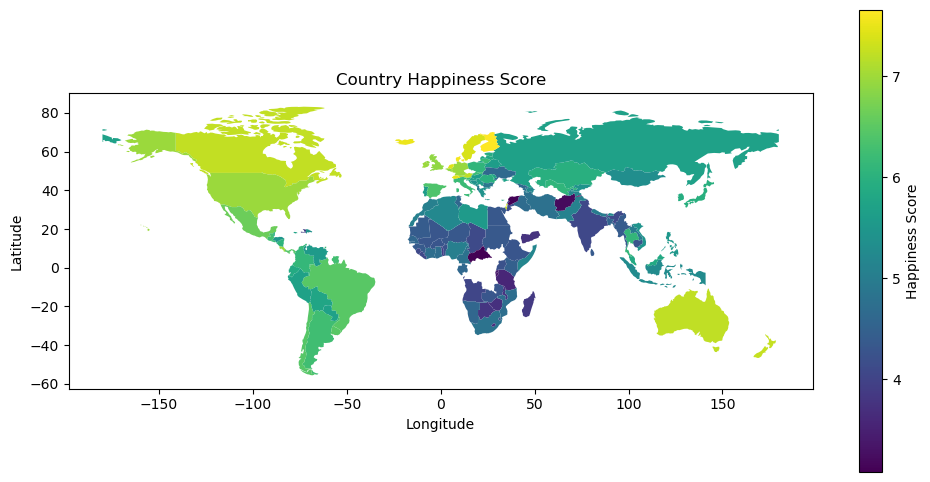

In [108]:

# Read country map images
world_maps = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge your data with the map data
world_happiness_merged = world_maps.merge(happiness_depression_df, left_on='iso_a3', right_on='Code_A3')

# Plot the map with colored tiles
fig, ax = plt.subplots(1, figsize=(12, 6))

world_happiness_merged.plot(column='Happiness Score', cmap='viridis', linewidth=0.4, ax=ax, legend=True, legend_kwds={'label': "Happiness Score"})
ax.set_title('Country Happiness Score')
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")

plt.savefig(f"../Images/Happiness Heat Map.png", bbox_inches="tight")

plt.show()

# Show plot based on lacation and the % of Population with Depression score marked by color intensity

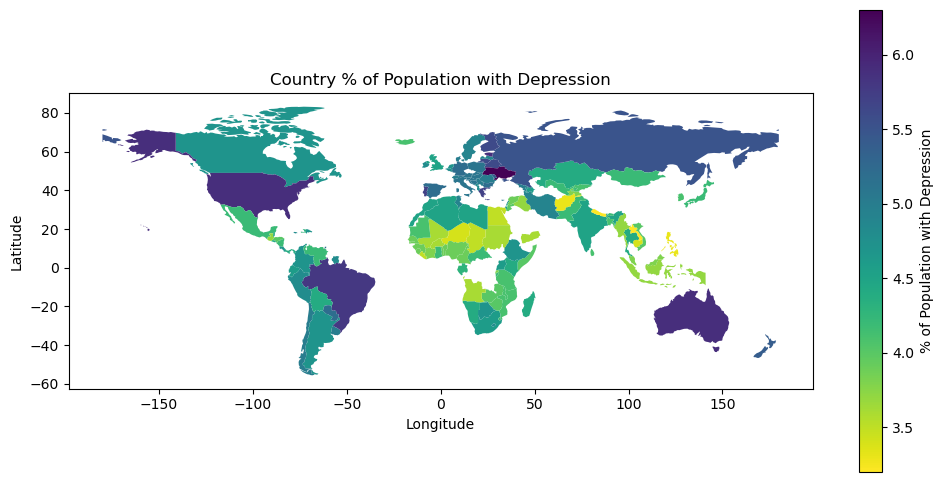

In [107]:
# Use previously read country map images

# world_happiness_merged contains depression data too
world_depression_merged = world_happiness_merged

# Plot the map with colored tiles
fig, ax = plt.subplots(1, figsize=(12, 6))

# getting the original colormap using cm.get_cmap() function
orig_map=plt.cm.get_cmap('viridis')
  
# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

world_depression_merged.plot(column='% of Pop with Depression', cmap=reversed_map, linewidth=0.4, ax=ax, legend=True, legend_kwds={'label': "% of Population with Depression"})
ax.set_title('Country % of Population with Depression')
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")

plt.savefig(f"../Images/Depression Heat Map.png", bbox_inches="tight")

plt.show()

In [80]:
# Display Happiness Score in box plots for Finland(top), Afghanistan(bottom) & Australia

Afghanistan potential outliers: Series([], Name: Score, dtype: float64)
Albania potential outliers: Series([], Name: Score, dtype: float64)
Algeria potential outliers: Series([], Name: Score, dtype: float64)
Angola potential outliers: Series([], Name: Score, dtype: float64)
Argentina potential outliers: Series([], Name: Score, dtype: float64)
Armenia potential outliers: Series([], Name: Score, dtype: float64)
Australia potential outliers: Series([], Name: Score, dtype: float64)
Austria potential outliers: Series([], Name: Score, dtype: float64)
Azerbaijan potential outliers: 0    4.911
Name: Score, dtype: float64
Bahrain potential outliers: Series([], Name: Score, dtype: float64)
Bangladesh potential outliers: Series([], Name: Score, dtype: float64)
Belarus potential outliers: Series([], Name: Score, dtype: float64)
Belgium potential outliers: Series([], Name: Score, dtype: float64)
Belize potential outliers: Series([], Name: Score, dtype: float64)
Benin potential outliers: Series([], 

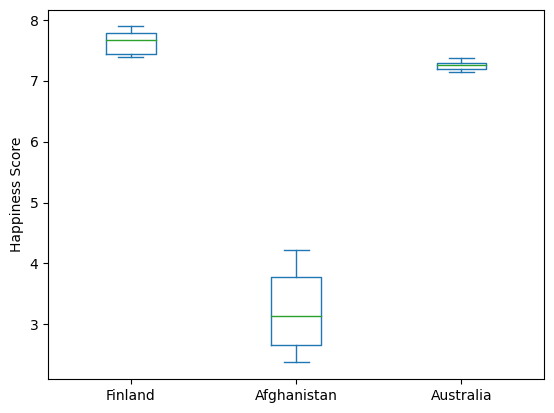

In [81]:
# Display box plots for 3 countries to show happiness outliers (Australia, Finland, Afghanistan)
happiness_df = pd.DataFrame()

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
for country in country_list:

    # Locate the rows for specific countries and get Happiness Score
    score = world_happiness_df.loc[world_happiness_df["Country"]==country, "Happiness Score"]

    # add subset 
    happiness_df["Score"] = pd.DataFrame(score.tolist())
    happiness_df[country] = pd.DataFrame(score.tolist())
    
    # Determine outliers using upper and lower bounds
    quartiles = happiness_df["Score"].quantile([0.25,0.5,0.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq-lowerq

    lower_bound = lowerq - (1.5*iqr)
    upper_bound = upperq + (1.5*iqr)
    
    outliers = happiness_df.loc[happiness_df["Score"]<lower_bound, "Score"]
    print(f"{country} potential outliers: {outliers}")


ax = happiness_df[["Finland", "Afghanistan", "Australia"]].plot(kind='box', sym='r')

ax.set_ylabel('Happiness Score')
plt.show()


In [82]:
# Create Happiness average score per year for all countries to represent the world
average_happiness_year_df = world_happiness_df.groupby("Year").mean()
average_happiness_year_df.head()

,Happiness Score,GDP p/capita,Social Support,Healthy Life Expectancy,Life Choices Freedom,Generosity,Corruption Perceptions,Positive Affect,Negative Effect
Year,,,,,,,,,
2012,5.421103,9.362579,0.807563,62.916032,0.704889,-0.008595,0.761889,0.641476,0.263468
2013,5.352357,9.339524,0.804532,62.945873,0.728384,-0.003656,0.761770,0.655288,0.271540
2014,5.364062,9.309877,0.806892,62.975692,0.737677,0.019062,0.739315,0.658868,0.272015
2015,5.375070,9.324711,0.796031,63.286719,0.750391,0.016078,0.735211,0.658859,0.277352
2016,5.383480,9.340448,0.810376,63.373200,0.762720,0.000096,0.747152,0.658944,0.286904


In [83]:
# Display Hppiness Score box plot for World,Australia, Finland

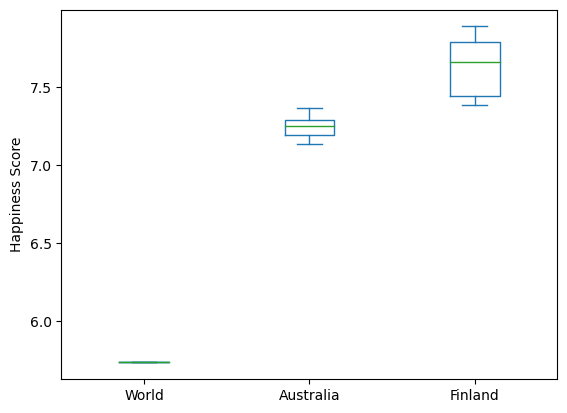

In [84]:
# Create box plots to compare the World, Australia and Finland
index = 0
for row in list(happiness_df["Finland"]):
    happiness_df["World"] = average_happiness_year_df.iloc[index, 0]
    index = index + 1
    

ax = happiness_df[["World", "Australia", "Finland"]].plot(kind='box', sym='r')
ax.set_ylabel('Happiness Score')

plt.show()

In [99]:
# Define a function to create Linear Regression plots
def plot_linear_regression(main_df, xcolumn_str, ycolumn_str, filename="default"):

    # Drop rows with null
    main_df = main_df.dropna()
    
    x_values = main_df[xcolumn_str]
    y_values = main_df[ycolumn_str]
    # Build the scatter plots 
    plt.scatter(x_values, y_values, marker='o', c=y_values)

    # Incorporate the other graph properties
    plt.title(f"{xcolumn_str} vs. {ycolumn_str}")
    plt.ylabel(ycolumn_str)
    plt.xlabel(xcolumn_str)

    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    
    # Get regression values
    regress_values = x_values * slope + intercept
    
    # Create line equation string
    line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

    plt.plot(x_values,regress_values,"r-")

    # Label plot and annotate the line equation
    x = x_values.min()
    y = y_values.min()
    plt.annotate(line_eq,(x, y),fontsize=15,color="red")

    # Print r value
    print(f"The r-value is: {rvalue**2}")

    plt.savefig(f"../Images/{filename}.png", bbox_inches="tight")

    # Show plot
    plt.show()

    return

# GDP p/capita vs Happiness Score

The r-value is: 0.6850391944585751


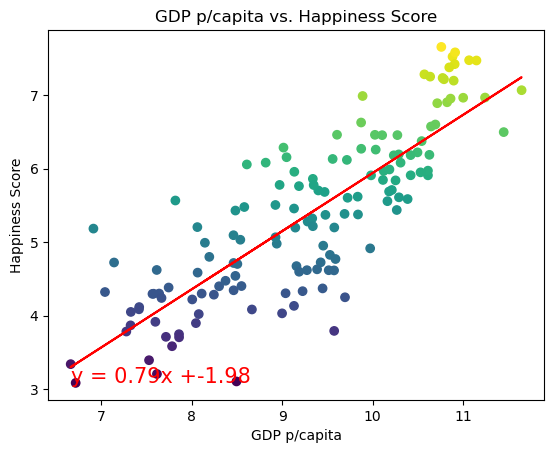

In [100]:
# Plot GDP vs Happiness Score
plot_linear_regression(happiness_depression_df, "GDP p/capita", "Happiness Score", "GDP vs Happiness")


#### GDP p/capita vs Happiness Score has a moderate correlation.

# GDP p/capita vs % of Pop with Depression

The r-value is: 0.4166441030275225


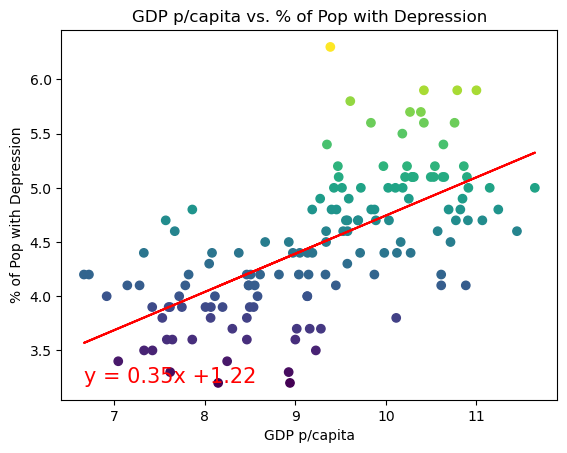

In [101]:
# Plot GDP vs Depression %
plot_linear_regression(happiness_depression_df, "GDP p/capita", "% of Pop with Depression", "GDP vs Depression")

#### GDP p/capita vs % of Pop with Depression has a weak correlation.

# Happiness Score vs % of Population with Depression

The r-value is: 0.2776394552152004


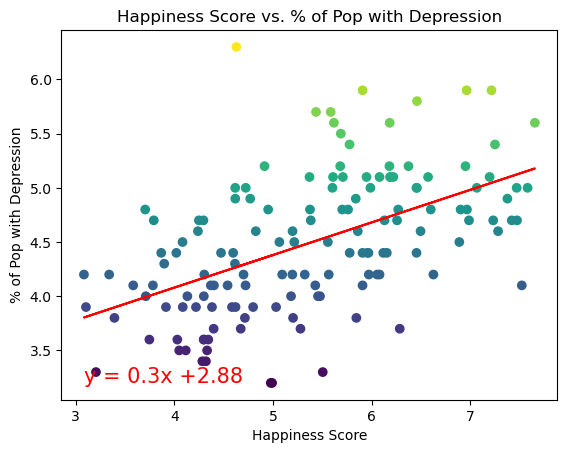

In [105]:
# Plot GDP vs Depression %
plot_linear_regression(happiness_depression_df, "Happiness Score", "% of Pop with Depression", "Happiness vs Depression")

#### Happiness vs % of Population with Depression has very weak or no correlation at all.